<a href="https://colab.research.google.com/github/Prima-Rizky/for-study-or-just-random/blob/main/ML_LCC_PDAM_KutaiTimur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔬 Analisis ML-LCC untuk Optimasi Pemeliharaan Jaringan Pipa Air Minum
## PDAM Kutai Timur — Studi Disertasi S3

**Judul:** Memetakan Algoritma Machine Learning untuk Analisis Life Cycle Costing Berbasis Prediksi dalam Optimasi Pemeliharaan Jaringan Pipa Air Minum

---

### 📌 Struktur Notebook
| Bagian | Isi |
|--------|-----|
| **A** | Instalasi & Setup |
| **B** | Pembuatan Data Dummy Realistis (500 segmen × 10 tahun) |
| **C** | Langkah 1 – EDA & Visualisasi Karakter Data |
| **D** | Langkah 2 – Preprocessing & Feature Engineering |
| **E** | Langkah 3 – Pelatihan & Evaluasi Semua Model ML |
| **F** | Langkah 4 – Optimasi LCC & Strategi Pemeliharaan |
| **G** | Social Cost Estimation |
| **H** | Analisis Sensitivitas |
| **I** | Ringkasan & Kesimpulan |


## A. Instalasi & Setup

In [ ]:
# Install semua library yang dibutuhkan
!pip install xgboost lightgbm shap imbalanced-learn optuna scikit-learn matplotlib seaborn pandas numpy scipy -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                              accuracy_score, precision_score, recall_score,
                              f1_score, classification_report, confusion_matrix)
from sklearn.model_selection import cross_val_score
import xgboost as xgb
import lightgbm as lgb
import shap
from imblearn.over_sampling import ADASYN

# TensorFlow untuk LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

# Style visualisasi
plt.rcParams.update({
    'figure.dpi': 120,
    'font.family': 'DejaVu Sans',
    'axes.spines.top': False,
    'axes.spines.right': False
})
sns.set_palette('husl')
print('✅ Setup selesai.')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 5.7 MB/s eta 0:00:00
✅ Setup selesai.


## B. Pembuatan Data Dummy Realistis PDAM Kutai Timur

> **Unit analisis:** 1 baris = 1 segmen pipa (100–300 m) dalam 1 tahun operasional  
> **Skala:** 500 segmen × 10 tahun = 5.000 observasi  
> **Semua nilai dikalibrasi** berdasarkan kondisi tipikal PDAM kabupaten di Kalimantan Timur

In [ ]:
np.random.seed(42)
N_SEGMEN = 500
N_TAHUN  = 10   # 2014–2023
N        = N_SEGMEN * N_TAHUN

tahun_list  = list(range(2014, 2024))
segmen_ids  = [f'PIPA-{i:04d}' for i in range(1, N_SEGMEN + 1)]

# ── Replikasi segmen x tahun ──────────────────────────────────────────────────
segmen_col = np.repeat(segmen_ids, N_TAHUN)
tahun_col  = np.tile(tahun_list, N_SEGMEN)

# ══════════════════════════════════════════════════════════════════════════════
# KLASTER A: Karakteristik Fisik Pipa
# ══════════════════════════════════════════════════════════════════════════════
material_base = np.random.choice(
    ['PVC', 'GI (Besi Galvanis)', 'HDPE', 'Besi Cor (CI)', 'Baja'],
    size=N_SEGMEN, p=[0.40, 0.25, 0.20, 0.10, 0.05]
)
material_col  = np.repeat(material_base, N_TAHUN)

diameter_base = np.random.choice([50, 75, 100, 150, 200, 250, 300],
                                  size=N_SEGMEN, p=[0.15,0.20,0.30,0.20,0.08,0.04,0.03])
diameter_col  = np.repeat(diameter_base, N_TAHUN)

panjang_base  = np.random.uniform(100, 300, size=N_SEGMEN)
panjang_col   = np.repeat(panjang_base, N_TAHUN)

# Umur pipa bertambah tiap tahun
umur_instalasi = np.random.randint(1, 25, size=N_SEGMEN)   # umur awal di 2014
umur_col = np.array([umur_instalasi[i] + (tahun_list[j] - 2014)
                     for i in range(N_SEGMEN) for j in range(N_TAHUN)])

# ══════════════════════════════════════════════════════════════════════════════
# KLASTER B: Kondisi Operasional
# ══════════════════════════════════════════════════════════════════════════════
tekanan_base = np.random.normal(3.5, 0.8, size=N_SEGMEN).clip(1.0, 7.0)  # bar
tekanan_col  = np.repeat(tekanan_base, N_TAHUN) + np.random.normal(0, 0.1, N)
tekanan_col  = tekanan_col.clip(1.0, 7.0)

debit_col    = (np.pi/4 * (diameter_col/1000)**2 * tekanan_col * 3600).round(2)  # m3/jam proxy

# ══════════════════════════════════════════════════════════════════════════════
# KLASTER C: Lingkungan & Geoteknik (KHAS KUTAI TIMUR)
# ══════════════════════════════════════════════════════════════════════════════
jenis_tanah_base = np.random.choice(
    ['Gambut', 'Lempung', 'Pasir', 'Batuan'],
    size=N_SEGMEN, p=[0.35, 0.40, 0.20, 0.05]
)
jenis_tanah_col = np.repeat(jenis_tanah_base, N_TAHUN)

# Indeks kelabilan tanah (0=stabil, 1=sangat labil) — khas Kutai Timur
kelabilan_map = {'Gambut': 0.75, 'Lempung': 0.50, 'Pasir': 0.35, 'Batuan': 0.10}
kelabilan_col = np.array([kelabilan_map[j] for j in jenis_tanah_col])
kelabilan_col += np.random.normal(0, 0.05, N)
kelabilan_col  = kelabilan_col.clip(0, 1)

# ★ KEBARUAN: Indeks Korosivitas Tanah
# Komposit dari: pH (invers), resistivitas (invers), klorida, sulfat, kelembapan
# Gambut → sangat korosif; Batuan → rendah
korosivitas_map = {'Gambut': 0.80, 'Lempung': 0.55, 'Pasir': 0.35, 'Batuan': 0.15}
korosivitas_col = np.array([korosivitas_map[j] for j in jenis_tanah_col])
korosivitas_col += np.random.normal(0, 0.06, N)
korosivitas_col  = korosivitas_col.clip(0, 1)

curah_hujan_col = np.random.normal(2200, 300, N).clip(1400, 3200)   # mm/tahun
muka_air_col    = np.random.normal(1.5, 0.5, N).clip(0.3, 4.0)     # meter

# ══════════════════════════════════════════════════════════════════════════════
# KLASTER D: Riwayat Kerusakan & Pemeliharaan
# ══════════════════════════════════════════════════════════════════════════════
# Probabilitas kegagalan dipengaruhi: umur, korosivitas, kelabilan, tekanan, material
material_risk = {'PVC': 0.05, 'HDPE': 0.04, 'GI (Besi Galvanis)': 0.15,
                 'Besi Cor (CI)': 0.20, 'Baja': 0.12}
mat_risk_col  = np.array([material_risk[m] for m in material_col])

pf_logit = (-3.5
            + 0.06  * umur_col
            + 2.0   * korosivitas_col
            + 1.5   * kelabilan_col
            + 0.3   * (tekanan_col - 3.5)
            + 3.0   * mat_risk_col
            + np.random.normal(0, 0.3, N))
pf_col = (1 / (1 + np.exp(-pf_logit))).clip(0.01, 0.99)   # Probabilitas kegagalan

# Jumlah kebocoran aktual per segmen per tahun (Poisson)
n_bocor_col = np.random.poisson(pf_col * 2)

# MTBF (Mean Time Between Failures) dalam bulan
mtbf_col = np.where(n_bocor_col > 0, 12 / n_bocor_col, 24).clip(1, 48)

# Failure rate λ = 1/MTBF (per bulan)
failure_rate_col = (1 / mtbf_col).round(4)

# Riwayat pemeliharaan (apakah ada PM tahun sebelumnya)
pm_history_col = np.random.binomial(1, 0.35, N)   # 35% pipa pernah PM

# ══════════════════════════════════════════════════════════════════════════════
# KLASTER E: Variabel Biaya (LCC Components) — dalam Rp juta
# ══════════════════════════════════════════════════════════════════════════════
# Biaya preventive maintenance
biaya_pm_col = (
    1.5 * panjang_col / 100          # Rp 1.5 juta per 100m
    + diameter_col * 0.05            # faktor diameter
    + np.random.normal(0, 0.5, N)
).clip(0.5, 20)

# Biaya corrective maintenance (lebih mahal, tergantung jumlah kebocoran)
biaya_cm_col = (
    n_bocor_col * (3.0 + diameter_col * 0.08)
    + np.random.normal(0, 1, N)
).clip(0, 80)

# Biaya penggantian (replacement)
biaya_replace_col = (
    panjang_col * (diameter_col / 100) * 1.2
    + np.random.normal(0, 5, N)
).clip(10, 500)

# ══════════════════════════════════════════════════════════════════════════════
# TARGET VARIABEL
# ══════════════════════════════════════════════════════════════════════════════
# TARGET 1: Biaya pemeliharaan aktual tahunan (Rp juta) — REGRESI
biaya_aktual_col = (
    biaya_pm_col * pm_history_col
    + biaya_cm_col
    + np.random.normal(0, 2, N)
).clip(0.1, 100)

# TARGET 2: Kelas Risiko Pipa — KLASIFIKASI
risiko_col = pd.cut(pf_col,
                    bins=[0, 0.25, 0.55, 0.80, 1.0],
                    labels=['Rendah', 'Sedang', 'Tinggi', 'Kritis'])

# ══════════════════════════════════════════════════════════════════════════════
# INJECT MISSING VALUES (realistis ±12%)
# ══════════════════════════════════════════════════════════════════════════════
def inject_missing(arr, rate=0.12):
    arr = arr.astype(float)
    idx = np.random.choice(len(arr), int(len(arr)*rate), replace=False)
    arr[idx] = np.nan
    return arr

curah_hujan_col  = inject_missing(curah_hujan_col, 0.10)
muka_air_col     = inject_missing(muka_air_col, 0.08)
biaya_pm_col     = inject_missing(biaya_pm_col, 0.15)
debit_col        = inject_missing(debit_col, 0.05)

# ══════════════════════════════════════════════════════════════════════════════
# SUSUN DATAFRAME
# ══════════════════════════════════════════════════════════════════════════════
df = pd.DataFrame({
    # Identitas
    'segmen_id'        : segmen_col,
    'tahun'            : tahun_col,
    # Klaster A
    'material'         : material_col,
    'diameter_mm'      : diameter_col,
    'panjang_m'        : panjang_col.round(1),
    'umur_tahun'       : umur_col,
    # Klaster B
    'tekanan_bar'      : tekanan_col.round(2),
    'debit_m3jam'      : debit_col.round(2),
    # Klaster C
    'jenis_tanah'      : jenis_tanah_col,
    'indeks_kelabilan' : kelabilan_col.round(3),
    'indeks_korosivitas': korosivitas_col.round(3),   # ★ KEBARUAN
    'curah_hujan_mm'   : curah_hujan_col.round(0),
    'muka_air_m'       : muka_air_col.round(2),
    # Klaster D
    'n_bocor'          : n_bocor_col,
    'mtbf_bulan'       : mtbf_col.round(1),
    'failure_rate'     : failure_rate_col,
    'pm_history'       : pm_history_col,
    # Klaster E
    'biaya_pm_juta'    : biaya_pm_col.round(2),
    'biaya_cm_juta'    : biaya_cm_col.round(2),
    'biaya_replace_juta': biaya_replace_col.round(2),
    # Target
    'prob_gagal'       : pf_col.round(4),
    'biaya_aktual_juta': biaya_aktual_col.round(2),
    'kelas_risiko'     : risiko_col
})

print(f'✅ Dataset berhasil dibuat: {df.shape[0]:,} baris × {df.shape[1]} kolom')
print(f"\n📊 Distribusi Kelas Risiko:")
print(df['kelas_risiko'].value_counts())
df.head(10)

✅ Dataset berhasil dibuat: 5,000 baris × 23 kolom

📊 Distribusi Kelas Risiko:
kelas_risiko
Sedang    2593
Tinggi    1383
Rendah     906
Kritis     118
Name: count, dtype: int64


,segmen_id,tahun,material,diameter_mm,panjang_m,umur_tahun,tekanan_bar,debit_m3jam,jenis_tanah,indeks_kelabilan,...,n_bocor,mtbf_bulan,failure_rate,pm_history,biaya_pm_juta,biaya_cm_juta,biaya_replace_juta,prob_gagal,biaya_aktual_juta,kelas_risiko
0,PIPA-0001,2014,PVC,150,137.0,16,4.08,NaN,Gambut,0.680,...,2,6.0,0.1667,1,9.44,29.45,239.76,0.6029,34.74,Tinggi
1,PIPA-0001,2015,PVC,150,137.0,17,4.26,271.13,Gambut,0.717,...,3,4.0,0.2500,0,9.19,44.96,244.41,0.7231,43.50,Tinggi
2,PIPA-0001,2016,PVC,150,137.0,18,4.60,292.34,Gambut,0.797,...,2,6.0,0.1667,1,10.31,29.32,244.46,0.7974,38.80,Tinggi
3,PIPA-0001,2017,PVC,150,137.0,19,4.15,263.71,Gambut,0.763,...,1,12.0,0.0833,0,8.89,15.04,242.67,0.6795,16.53,Tinggi
4,PIPA-0001,2018,PVC,150,137.0,20,4.09,260.08,Gambut,0.702,...,0,24.0,0.0417,0,9.50,0.00,243.74,0.4469,0.10,Sedang
5,PIPA-0001,2019,PVC,150,137.0,21,4.46,283.95,Gambut,0.668,...,2,6.0,0.1667,1,8.90,30.37,245.20,0.7413,42.60,Tinggi
6,PIPA-0001,2020,PVC,150,137.0,22,4.34,276.35,Gambut,0.817,...,1,12.0,0.0833,0,10.04,13.90,238.02,0.7617,15.20,Tinggi
7,PIPA-0001,2021,PVC,150,137.0,23,4.29,272.82,Gambut,0.647,...,0,24.0,0.0417,1,9.62,0.01,250.56,0.8097,9.30,Kritis
8,PIPA-0001,2022,PVC,150,137.0,24,4.41,280.30,Gambut,0.782,...,1,12.0,0.0833,0,9.01,15.00,248.76,0.6875,15.72,Tinggi
9,PIPA-0001,2023,PVC,150,137.0,25,4.19,266.34,Gambut,0.723,...,1,12.0,0.0833,1,9.60,15.18,244.48,0.7824,28.53,Tinggi


## C. Langkah 1 — EDA & Visualisasi Karakter Data

In [ ]:
# ── C1. Ringkasan Statistik Deskriptif ────────────────────────────────────────
print('='*70)
print('STATISTIK DESKRIPTIF — DATA DUMMY PDAM KUTAI TIMUR')
print('='*70)
display(df.describe(include='all').T)

STATISTIK DESKRIPTIF — DATA DUMMY PDAM KUTAI TIMUR


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
segmen_id,5000,500,PIPA-0500,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tahun,5000.0,NaN,NaN,NaN,2018.5,2.872569,2014.0,2016.0,2018.5,2021.0,2023.0
material,5000,5,PVC,2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diameter_mm,5000.0,NaN,NaN,NaN,113.25,56.800817,50.0,75.0,100.0,150.0,300.0
panjang_m,5000.0,NaN,NaN,NaN,203.5098,59.385823,101.0,148.25,207.95,255.45,299.9
umur_tahun,5000.0,NaN,NaN,NaN,16.75,7.573967,1.0,11.0,17.0,23.0,33.0
tekanan_bar,5000.0,NaN,NaN,NaN,3.525242,0.82037,1.0,2.97,3.5,4.09,6.13
debit_m3jam,4750.0,NaN,NaN,NaN,160.375368,184.476172,9.65,50.645,91.54,209.0325,1402.59
jenis_tanah,5000,4,Lempung,2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
indeks_kelabilan,5000.0,NaN,NaN,NaN,0.5285,0.180241,0.0,0.408,0.508,0.706,0.908


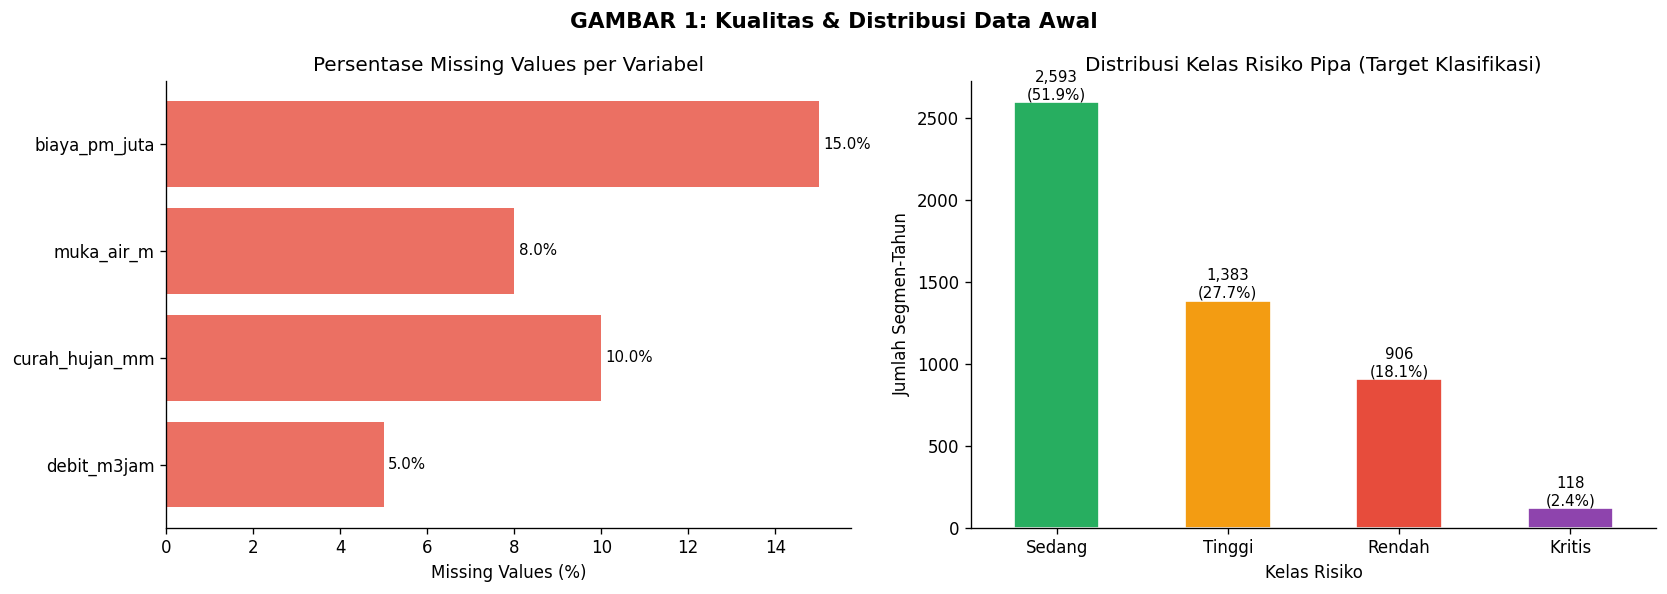

💾 Tersimpan: gambar1_data_overview.png


In [ ]:
# ── C2. Distribusi Missing Values ─────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

missing = df.isnull().sum()
missing = missing[missing > 0]
missing_pct = (missing / len(df) * 100).round(1)

axes[0].barh(missing.index, missing_pct, color='#E74C3C', alpha=0.8)
axes[0].set_xlabel('Missing Values (%)')
axes[0].set_title('Persentase Missing Values per Variabel')
for i, v in enumerate(missing_pct):
    axes[0].text(v + 0.1, i, f'{v}%', va='center', fontsize=9)

# Distribusi kelas risiko
colors_risiko = ['#27AE60', '#F39C12', '#E74C3C', '#8E44AD']
df['kelas_risiko'].value_counts().plot(kind='bar', ax=axes[1],
    color=colors_risiko, edgecolor='white', rot=0)
axes[1].set_title('Distribusi Kelas Risiko Pipa (Target Klasifikasi)')
axes[1].set_xlabel('Kelas Risiko')
axes[1].set_ylabel('Jumlah Segmen-Tahun')
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height()):,}\n({p.get_height()/len(df)*100:.1f}%)',
                     (p.get_x() + p.get_width()/2, p.get_height()),
                     ha='center', va='bottom', fontsize=9)

plt.suptitle('GAMBAR 1: Kualitas & Distribusi Data Awal', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('gambar1_data_overview.png', bbox_inches='tight')
plt.show()
print('💾 Tersimpan: gambar1_data_overview.png')

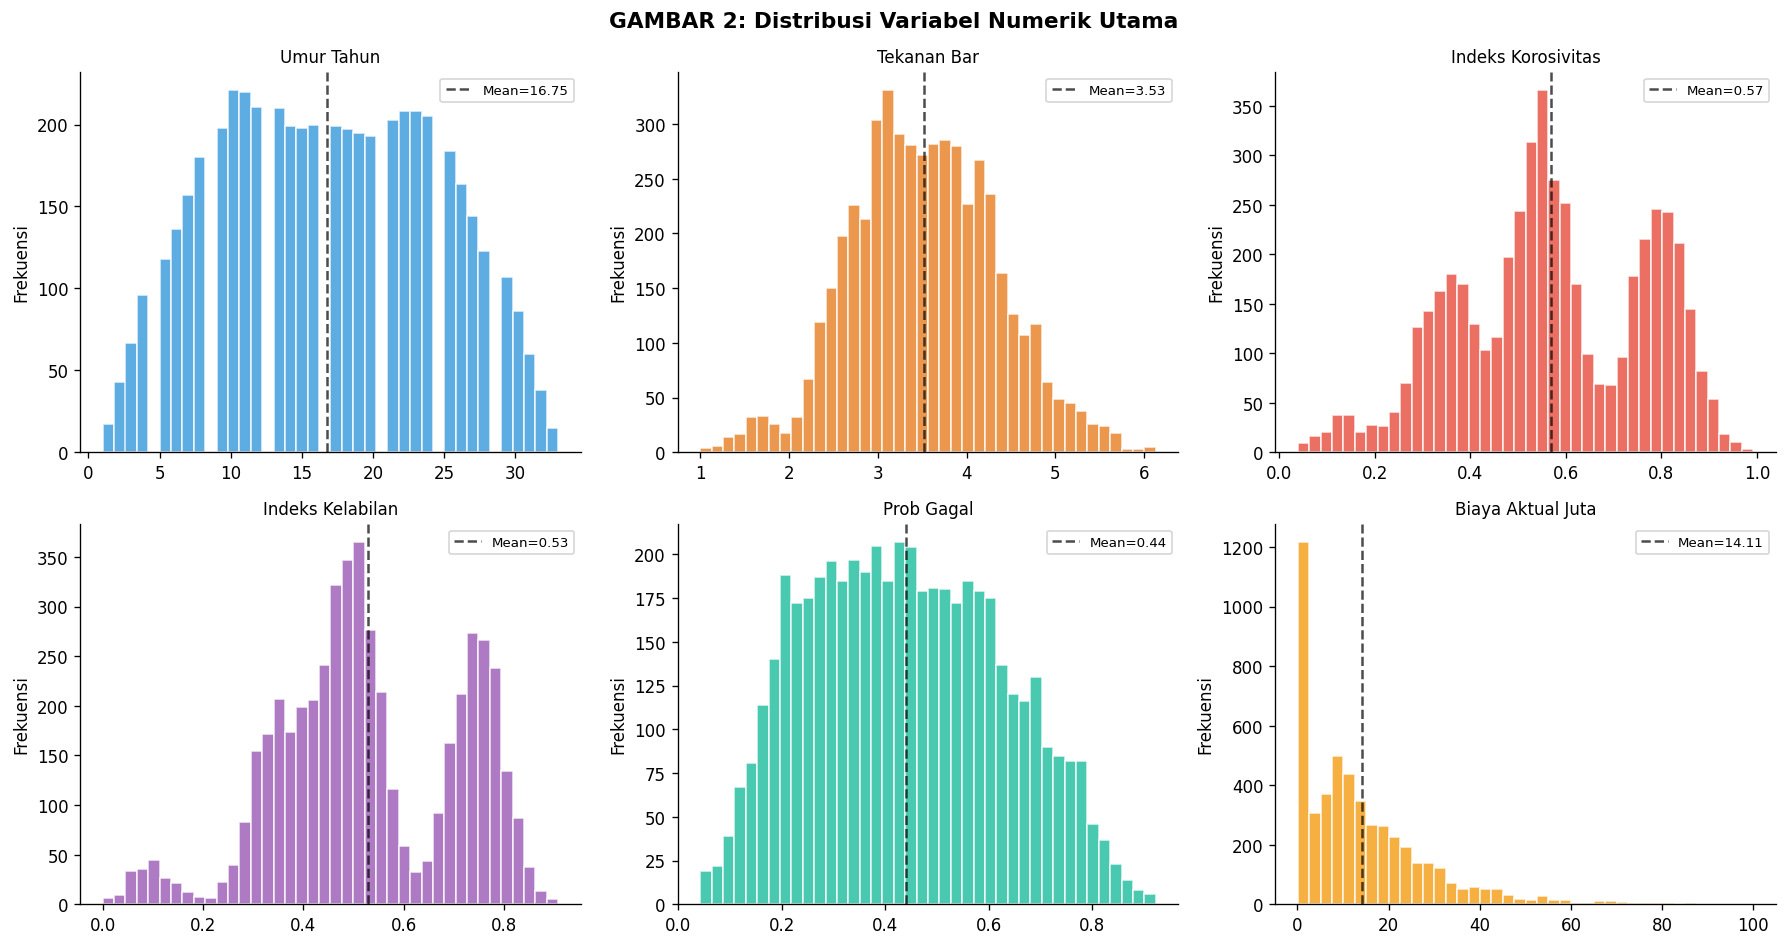

💾 Tersimpan: gambar2_distribusi_variabel.png


In [ ]:
# ── C3. Distribusi Variabel Numerik Utama ─────────────────────────────────────
num_vars = ['umur_tahun', 'tekanan_bar', 'indeks_korosivitas',
            'indeks_kelabilan', 'prob_gagal', 'biaya_aktual_juta']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
colors = ['#3498DB','#E67E22','#E74C3C','#9B59B6','#1ABC9C','#F39C12']

for i, (var, color) in enumerate(zip(num_vars, colors)):
    axes[i].hist(df[var].dropna(), bins=40, color=color, alpha=0.8, edgecolor='white')
    axes[i].set_title(var.replace('_', ' ').title(), fontsize=10)
    axes[i].set_ylabel('Frekuensi')
    mu = df[var].dropna().mean()
    axes[i].axvline(mu, color='black', linestyle='--', alpha=0.7, label=f'Mean={mu:.2f}')
    axes[i].legend(fontsize=8)

plt.suptitle('GAMBAR 2: Distribusi Variabel Numerik Utama', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('gambar2_distribusi_variabel.png', bbox_inches='tight')
plt.show()
print('💾 Tersimpan: gambar2_distribusi_variabel.png')

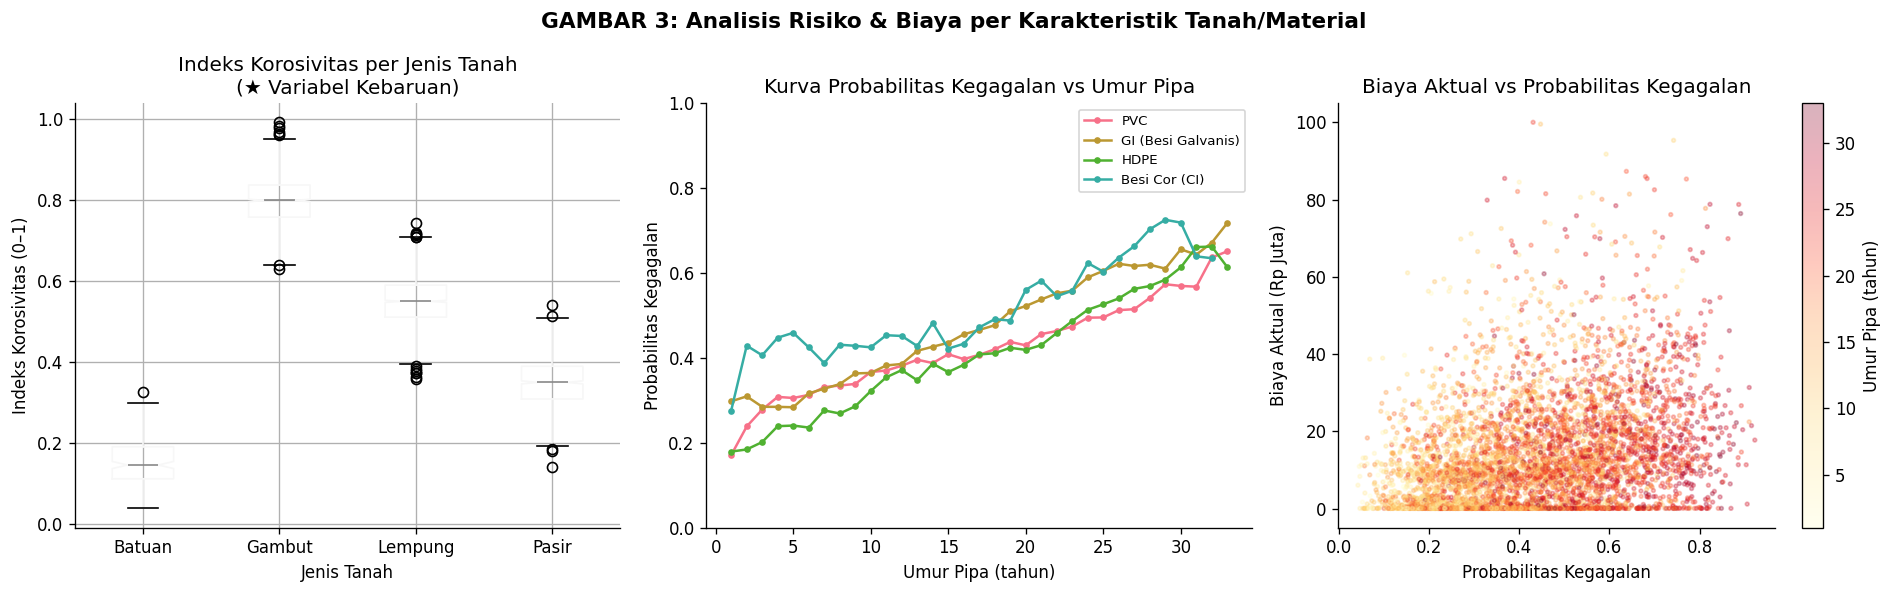

💾 Tersimpan: gambar3_risiko_biaya.png


In [ ]:
# ── C4. Korosivitas & Kelabilan per Jenis Tanah — KHAS KUTAI TIMUR ─────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Boxplot korosivitas per jenis tanah
order_tanah = ['Gambut', 'Lempung', 'Pasir', 'Batuan']
df.boxplot(column='indeks_korosivitas', by='jenis_tanah',
           ax=axes[0], notch=True)
axes[0].set_title('Indeks Korosivitas per Jenis Tanah\n(★ Variabel Kebaruan)')
axes[0].set_xlabel('Jenis Tanah')
axes[0].set_ylabel('Indeks Korosivitas (0–1)')

# Prob kegagalan vs umur pipa per material
for mat in ['PVC', 'GI (Besi Galvanis)', 'HDPE', 'Besi Cor (CI)']:
    subset = df[df['material'] == mat].groupby('umur_tahun')['prob_gagal'].mean()
    axes[1].plot(subset.index, subset.values, label=mat, marker='o', markersize=3)
axes[1].set_title('Kurva Probabilitas Kegagalan vs Umur Pipa')
axes[1].set_xlabel('Umur Pipa (tahun)')
axes[1].set_ylabel('Probabilitas Kegagalan')
axes[1].legend(fontsize=8)
axes[1].set_ylim(0, 1)

# Biaya aktual vs probabilitas kegagalan (scatter)
sc = axes[2].scatter(df['prob_gagal'], df['biaya_aktual_juta'],
                     c=df['umur_tahun'], cmap='YlOrRd', alpha=0.3, s=5)
plt.colorbar(sc, ax=axes[2], label='Umur Pipa (tahun)')
axes[2].set_title('Biaya Aktual vs Probabilitas Kegagalan')
axes[2].set_xlabel('Probabilitas Kegagalan')
axes[2].set_ylabel('Biaya Aktual (Rp Juta)')

plt.suptitle('GAMBAR 3: Analisis Risiko & Biaya per Karakteristik Tanah/Material',
             fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('gambar3_risiko_biaya.png', bbox_inches='tight')
plt.show()
print('💾 Tersimpan: gambar3_risiko_biaya.png')

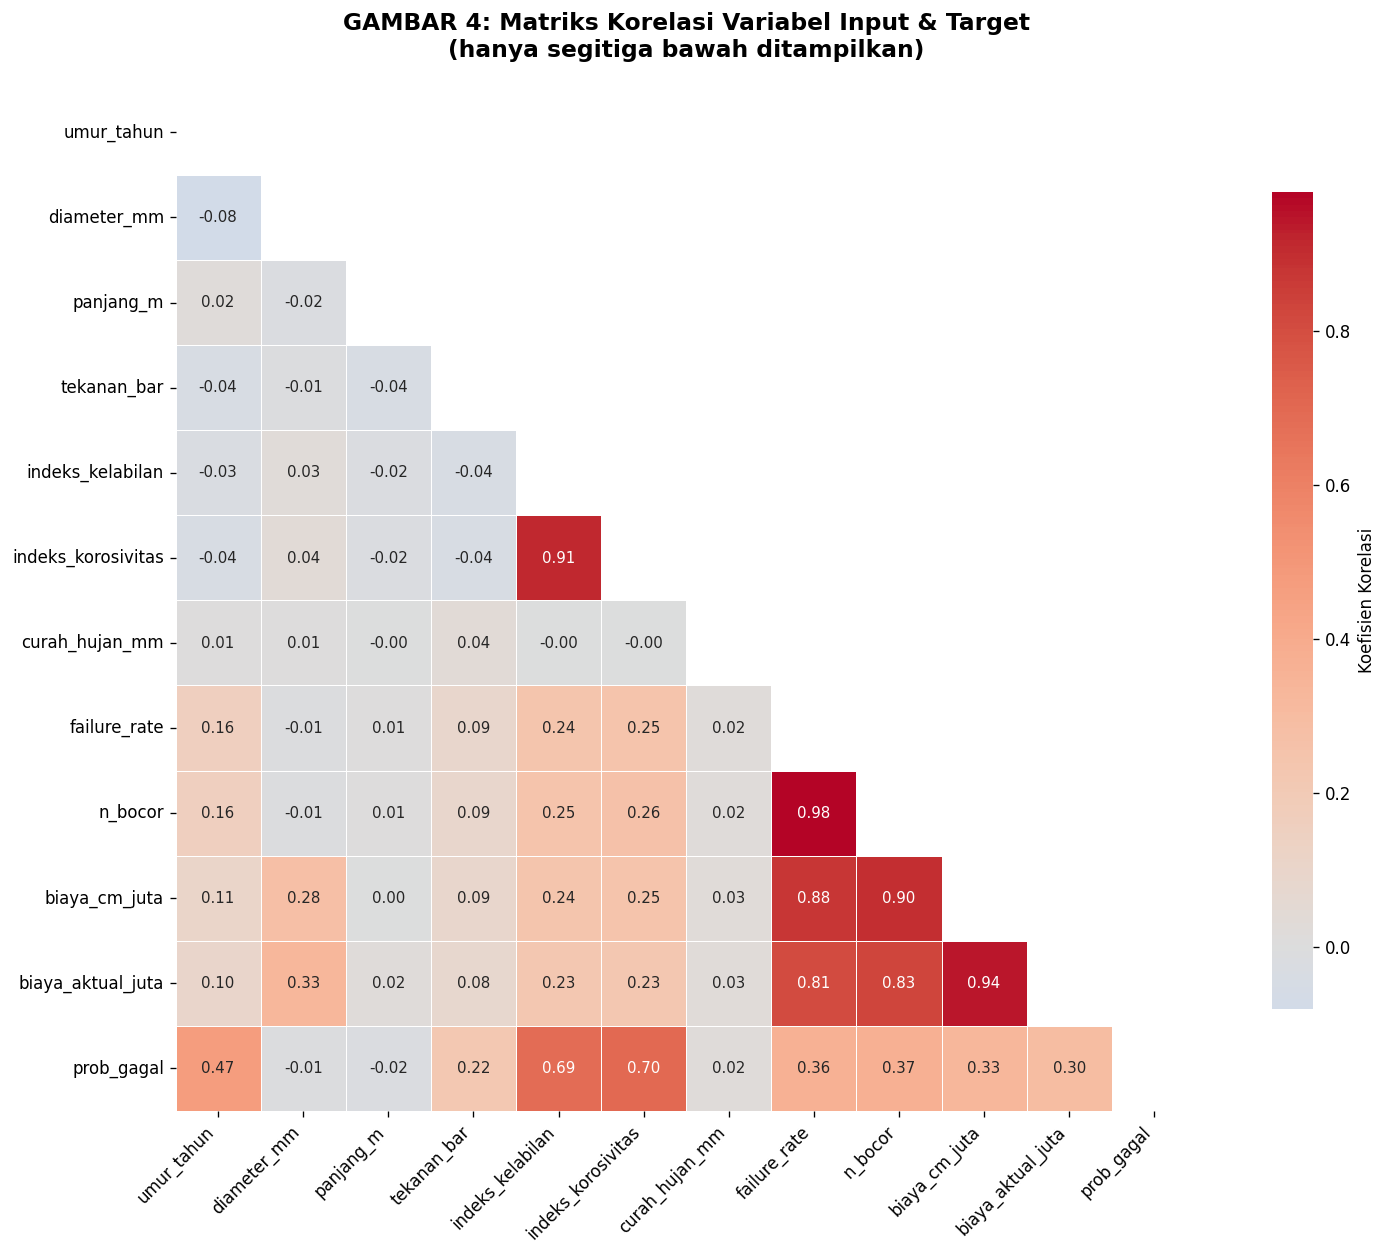

💾 Tersimpan: gambar4_korelasi_perbaikan.png


In [ ]:
# ── C5. Heatmap Korelasi ──────────────────────────────────────────────────────
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['umur_tahun', 'diameter_mm', 'panjang_m', 'tekanan_bar',
            'indeks_kelabilan', 'indeks_korosivitas', 'curah_hujan_mm',
            'failure_rate', 'n_bocor', 'biaya_cm_juta', 'biaya_aktual_juta', 'prob_gagal']

corr = df[num_cols].corr().round(2)   # bulatkan 2 desimal sejak awal

# Buat figure lebih besar agar teks punya ruang bernapas
fig, ax = plt.subplots(figsize=(14, 11))

# Mask hanya untuk segitiga atas (termasuk diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap utama
sns.heatmap(
    corr,
    mask=mask,                     # sembunyikan segitiga atas
    annot=True,                    # tampilkan angka
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.6,
    linecolor='white',
    cbar_kws={'label': 'Koefisien Korelasi', 'shrink': 0.8},
    annot_kws={'size': 9, 'weight': 'normal'},  # sedikit lebih kecil & normal weight
    square=True,                   # sel persegi
    ax=ax
)

# Hilangkan anotasi yang mungkin "nyasar" di bagian masked (opsional tapi membantu)
for text in ax.texts:
    if text.get_position()[0] > text.get_position()[1]:  # hanya segitiga bawah
        continue
    # Jika teks di luar batas yang diinginkan, bisa di-skip atau diatur ulang
    # (jarang dibutuhkan jika mask benar)

# Atur label sumbu dengan rotasi supaya tidak tumpang tindih
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

# Judul lebih jelas
ax.set_title('GAMBAR 4: Matriks Korelasi Variabel Input & Target\n'
             '(hanya segitiga bawah ditampilkan)',
             fontweight='bold', fontsize=14, pad=20)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # beri ruang untuk judul
plt.savefig('gambar4_korelasi_perbaikan.png', dpi=150, bbox_inches='tight')
plt.show()

print('💾 Tersimpan: gambar4_korelasi_perbaikan.png')

## D. Langkah 2 — Preprocessing & Feature Engineering

In [ ]:
# ── D1. KNN Imputation untuk Missing Values ───────────────────────────────────
print('📋 Missing values SEBELUM imputasi:')
print(df.isnull().sum()[df.isnull().sum() > 0])

num_impute_cols = ['curah_hujan_mm', 'muka_air_m', 'biaya_pm_juta', 'debit_m3jam']
imputer = KNNImputer(n_neighbors=5)
df[num_impute_cols] = imputer.fit_transform(df[num_impute_cols])

print('\n✅ Missing values SETELAH KNN Imputation:')
print(df.isnull().sum()[df.isnull().sum() > 0])
print('   → Tidak ada missing values tersisa.')

📋 Missing values SEBELUM imputasi:
debit_m3jam       250
curah_hujan_mm    500
muka_air_m        400
biaya_pm_juta     750
dtype: int64

✅ Missing values SETELAH KNN Imputation:
Series([], dtype: int64)
   → Tidak ada missing values tersisa.


In [ ]:
# ── D2. Encoding Variabel Kategorikal ────────────────────────────────────────
le_material = LabelEncoder()
le_tanah    = LabelEncoder()
le_risiko   = LabelEncoder()

df['material_enc']     = le_material.fit_transform(df['material'])
df['jenis_tanah_enc']  = le_tanah.fit_transform(df['jenis_tanah'])
df['kelas_risiko_enc'] = le_risiko.fit_transform(df['kelas_risiko'])

print('Mapping Material:')
for cls, code in zip(le_material.classes_, range(len(le_material.classes_))):
    print(f'  {code} → {cls}')
print('\nMapping Jenis Tanah:')
for cls, code in zip(le_tanah.classes_, range(len(le_tanah.classes_))):
    print(f'  {code} → {cls}')
print('\nMapping Kelas Risiko:')
for cls, code in zip(le_risiko.classes_, range(len(le_risiko.classes_))):
    print(f'  {code} → {cls}')

Mapping Material:
  0 → Baja
  1 → Besi Cor (CI)
  2 → GI (Besi Galvanis)
  3 → HDPE
  4 → PVC

Mapping Jenis Tanah:
  0 → Batuan
  1 → Gambut
  2 → Lempung
  3 → Pasir

Mapping Kelas Risiko:
  0 → Kritis
  1 → Rendah
  2 → Sedang
  3 → Tinggi


In [ ]:
# ── D3. Feature Engineering ───────────────────────────────────────────────────
# Umur Pipa Ternormalisasi
df['umur_norm']       = df['umur_tahun'] / df['umur_tahun'].max()

# Faktor Risiko Komposit
df['risiko_komposit'] = (0.4 * df['indeks_korosivitas']
                        + 0.35 * df['indeks_kelabilan']
                        + 0.25 * df['umur_norm'])

# Laju Kerusakan Kumulatif
df['laju_kerusakan']  = df.groupby('segmen_id')['n_bocor'].cumsum()

# Interaksi: Umur × Korosivitas (penting untuk pipa besi)
df['umur_x_korosiv']  = df['umur_tahun'] * df['indeks_korosivitas']

# Ratio biaya: CM/PM
df['rasio_cm_pm']     = df['biaya_cm_juta'] / (df['biaya_pm_juta'] + 0.01)

# Remaining Useful Life (RUL) estimasi sederhana
df['rul_tahun']       = (30 - df['umur_tahun']).clip(0, 30)   # asumsi umur desain 30 thn

print('✅ Feature Engineering selesai. Variabel baru yang ditambahkan:')
new_features = ['umur_norm','risiko_komposit','laju_kerusakan','umur_x_korosiv','rasio_cm_pm','rul_tahun']
print(df[new_features].describe().round(3))

✅ Feature Engineering selesai. Variabel baru yang ditambahkan:
       umur_norm  risiko_komposit  laju_kerusakan  umur_x_korosiv  \
count   5000.000         5000.000        5000.000        5000.000   
mean       0.508            0.539           4.672           9.477   
std        0.230            0.147           4.012           5.540   
min        0.030            0.098           0.000           0.269   
25%        0.333            0.441           2.000           5.234   
50%        0.515            0.530           4.000           8.528   
75%        0.697            0.655           7.000          12.896   
max        1.000            0.918          23.000          30.752   

       rasio_cm_pm  rul_tahun  
count     5000.000   5000.000  
mean         1.243     13.286  
std          1.432      7.506  
min          0.000      0.000  
25%          0.019      7.000  
50%          1.130     13.000  
75%          1.749     19.000  
max          9.942     29.000  


In [ ]:
# ── D4. Time-Based Split (WAJIB untuk S3) ────────────────────────────────────
# Train: 2014–2020 | Validation: 2021 | Test: 2022–2023
TRAIN_YEARS = list(range(2014, 2021))
VAL_YEARS   = [2021]
TEST_YEARS  = [2022, 2023]

FEATURES = [
    'umur_tahun', 'diameter_mm', 'panjang_m', 'tekanan_bar', 'debit_m3jam',
    'material_enc', 'jenis_tanah_enc',
    'indeks_kelabilan', 'indeks_korosivitas', 'curah_hujan_mm', 'muka_air_m',
    'n_bocor', 'mtbf_bulan', 'failure_rate', 'pm_history',
    'biaya_pm_juta', 'biaya_cm_juta',
    'umur_norm', 'risiko_komposit', 'laju_kerusakan', 'umur_x_korosiv',
    'rasio_cm_pm', 'rul_tahun'
]

TARGET_REG  = 'biaya_aktual_juta'
TARGET_CLF  = 'kelas_risiko_enc'

train_df = df[df['tahun'].isin(TRAIN_YEARS)]
val_df   = df[df['tahun'].isin(VAL_YEARS)]
test_df  = df[df['tahun'].isin(TEST_YEARS)]

X_train = train_df[FEATURES]
X_val   = val_df[FEATURES]
X_test  = test_df[FEATURES]

y_train_reg = train_df[TARGET_REG]
y_val_reg   = val_df[TARGET_REG]
y_test_reg  = test_df[TARGET_REG]

y_train_clf = train_df[TARGET_CLF]
y_val_clf   = val_df[TARGET_CLF]
y_test_clf  = test_df[TARGET_CLF]

print(f'📅 Time-Based Split:')
print(f'   Train  (2014–2020): {len(X_train):,} baris')
print(f'   Val    (2021)     : {len(X_val):,} baris')
print(f'   Test   (2022–2023): {len(X_test):,} baris')

📅 Time-Based Split:
   Train  (2014–2020): 3,500 baris
   Val    (2021)     : 500 baris
   Test   (2022–2023): 1,000 baris


In [ ]:
# ── D5. Normalisasi (untuk ANN & LSTM) ───────────────────────────────────────
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_sc = scaler_X.fit_transform(X_train)
X_val_sc   = scaler_X.transform(X_val)
X_test_sc  = scaler_X.transform(X_test)

y_train_sc = scaler_y.fit_transform(y_train_reg.values.reshape(-1,1)).ravel()
y_val_sc   = scaler_y.transform(y_val_reg.values.reshape(-1,1)).ravel()
y_test_sc  = scaler_y.transform(y_test_reg.values.reshape(-1,1)).ravel()

# ── D6. Penanganan Imbalance: Class-Weighted (utama) + ADASYN (pembanding) ──
from collections import Counter
print('Distribusi kelas SEBELUM penanganan:')
print(Counter(y_train_clf))

# ADASYN (hanya numerik)
try:
    adasyn = ADASYN(random_state=42)
    X_train_ada, y_train_ada = adasyn.fit_resample(X_train, y_train_clf)
    print('\nDistribusi kelas SETELAH ADASYN:')
    print(Counter(y_train_ada))
except Exception as e:
    print(f'ADASYN: {e} → gunakan original data dengan class_weight')
    X_train_ada, y_train_ada = X_train, y_train_clf

print('\n✅ Strategi utama: class_weight="balanced" pada semua model klasifikasi')

Distribusi kelas SEBELUM penanganan:
Counter({2: 1839, 3: 874, 1: 732, 0: 55})

Distribusi kelas SETELAH ADASYN:
Counter({0: 1855, 3: 1843, 2: 1839, 1: 1815})

✅ Strategi utama: class_weight="balanced" pada semua model klasifikasi


## E. Langkah 3 — Pelatihan & Evaluasi Semua Model ML

In [ ]:
# ── Helper: Fungsi Evaluasi ───────────────────────────────────────────────────
def eval_regression(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {'Model': name, 'RMSE': round(rmse,3), 'MAE': round(mae,3), 'R²': round(r2,4)}

def eval_classification(name, y_true, y_pred):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return {'Model': name, 'Accuracy': round(acc,4), 'Precision': round(prec,4),
            'Recall': round(rec,4), 'F1-Score': round(f1,4)}

results_reg = []
results_clf = []
models_reg  = {}
models_clf  = {}

In [ ]:
# ── E1. BASELINE: Linear Regression & Decision Tree ──────────────────────────
print('⏳ Training baseline models...')

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train_reg)
results_reg.append(eval_regression('Linear Regression', y_test_reg, lr.predict(X_test)))
models_reg['Linear Regression'] = lr

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(max_depth=8, random_state=42)
dt_reg.fit(X_train, y_train_reg)
results_reg.append(eval_regression('Decision Tree', y_test_reg, dt_reg.predict(X_test)))
models_reg['Decision Tree'] = dt_reg

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=8, class_weight='balanced', random_state=42)
dt_clf.fit(X_train, y_train_clf)
results_clf.append(eval_classification('Decision Tree', y_test_clf, dt_clf.predict(X_test)))
models_clf['Decision Tree'] = dt_clf

print('✅ Baseline selesai.')

⏳ Training baseline models...
✅ Baseline selesai.


In [ ]:
# ── E2. RANDOM FOREST ─────────────────────────────────────────────────────────
print('⏳ Training Random Forest...')

rf_reg = RandomForestRegressor(n_estimators=200, max_depth=15,
                                min_samples_leaf=5, n_jobs=-1, random_state=42)
rf_reg.fit(X_train, y_train_reg)
results_reg.append(eval_regression('Random Forest', y_test_reg, rf_reg.predict(X_test)))
models_reg['Random Forest'] = rf_reg

rf_clf = RandomForestClassifier(n_estimators=200, max_depth=15,
                                 class_weight='balanced', n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train_clf)
results_clf.append(eval_classification('Random Forest', y_test_clf, rf_clf.predict(X_test)))
models_clf['Random Forest'] = rf_clf

print('✅ Random Forest selesai.')

⏳ Training Random Forest...
✅ Random Forest selesai.


In [ ]:
# ── E3. XGBOOST ───────────────────────────────────────────────────────────────
print('⏳ Training XGBoost...')

xgb_reg = xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05,
                             subsample=0.8, colsample_bytree=0.8,
                             random_state=42, verbosity=0)
xgb_reg.fit(X_train, y_train_reg,
            eval_set=[(X_val, y_val_reg)],
            verbose=False)
results_reg.append(eval_regression('XGBoost', y_test_reg, xgb_reg.predict(X_test)))
models_reg['XGBoost'] = xgb_reg

# Hitung scale_pos_weight untuk imbalanced
class_counts = Counter(y_train_clf)
xgb_clf = xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                              subsample=0.8, colsample_bytree=0.8,
                              use_label_encoder=False, eval_metric='mlogloss',
                              random_state=42, verbosity=0)
xgb_clf.fit(X_train, y_train_clf, verbose=False)
results_clf.append(eval_classification('XGBoost', y_test_clf, xgb_clf.predict(X_test)))
models_clf['XGBoost'] = xgb_clf

print('✅ XGBoost selesai.')

⏳ Training XGBoost...
✅ XGBoost selesai.


In [ ]:
# ── E4. LIGHTGBM ──────────────────────────────────────────────────────────────
print('⏳ Training LightGBM...')

lgb_reg = lgb.LGBMRegressor(n_estimators=300, max_depth=6, learning_rate=0.05,
                              subsample=0.8, colsample_bytree=0.8,
                              random_state=42, verbose=-1)
lgb_reg.fit(X_train, y_train_reg,
            eval_set=[(X_val, y_val_reg)],
            callbacks=[lgb.early_stopping(50, verbose=False)])
results_reg.append(eval_regression('LightGBM', y_test_reg, lgb_reg.predict(X_test)))
models_reg['LightGBM'] = lgb_reg

lgb_clf = lgb.LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.05,
                               class_weight='balanced', random_state=42, verbose=-1)
lgb_clf.fit(X_train, y_train_clf,
            eval_set=[(X_val, y_val_clf)],
            callbacks=[lgb.early_stopping(50, verbose=False)])
results_clf.append(eval_classification('LightGBM', y_test_clf, lgb_clf.predict(X_test)))
models_clf['LightGBM'] = lgb_clf

print('✅ LightGBM selesai.')

⏳ Training LightGBM...
✅ LightGBM selesai.


In [ ]:
# ── E5. SVR ───────────────────────────────────────────────────────────────────
print('⏳ Training SVR (subset 2000 data untuk kecepatan)...')
idx_sub = np.random.choice(len(X_train_sc), min(2000, len(X_train_sc)), replace=False)

svr = SVR(kernel='rbf', C=10, epsilon=0.5)
svr.fit(X_train_sc[idx_sub], y_train_sc[idx_sub])
y_svr_pred_sc = svr.predict(X_test_sc)
y_svr_pred = scaler_y.inverse_transform(y_svr_pred_sc.reshape(-1,1)).ravel()
results_reg.append(eval_regression('SVR', y_test_reg, y_svr_pred))
models_reg['SVR'] = svr

print('✅ SVR selesai.')

⏳ Training SVR (subset 2000 data untuk kecepatan)...
✅ SVR selesai.


In [ ]:
# ── E6. ANN / MLP ─────────────────────────────────────────────────────────────
print('⏳ Training ANN/MLP...')

ann_reg = MLPRegressor(hidden_layer_sizes=(128, 64, 32), activation='relu',
                        max_iter=500, random_state=42, early_stopping=True,
                        validation_fraction=0.1)
ann_reg.fit(X_train_sc, y_train_sc)
y_ann_pred_sc = ann_reg.predict(X_test_sc)
y_ann_pred    = scaler_y.inverse_transform(y_ann_pred_sc.reshape(-1,1)).ravel()
results_reg.append(eval_regression('ANN/MLP', y_test_reg, y_ann_pred))
models_reg['ANN/MLP'] = ann_reg

ann_clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32), activation='relu',
                         max_iter=500, random_state=42, early_stopping=True)
ann_clf.fit(X_train_sc, y_train_clf)
results_clf.append(eval_classification('ANN/MLP', y_test_clf, ann_clf.predict(X_test_sc)))
models_clf['ANN/MLP'] = ann_clf

print('✅ ANN/MLP selesai.')

⏳ Training ANN/MLP...
✅ ANN/MLP selesai.


⏳ Training LSTM (time-series prediksi biaya tahunan)...


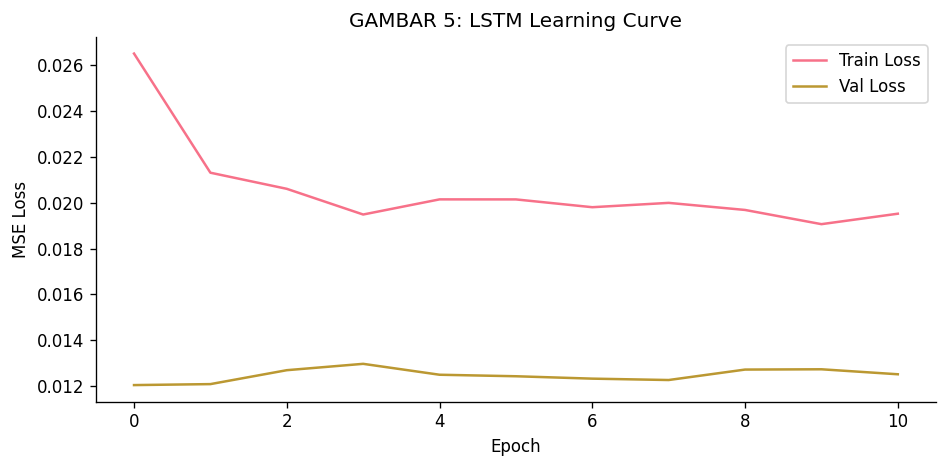

💾 Tersimpan: gambar5_lstm_curve.png


In [ ]:
# ── E7. LSTM (Time-Series) ────────────────────────────────────────────────────
print('⏳ Training LSTM (time-series prediksi biaya tahunan)...')

# Susun sequence: tiap segmen pipa sebagai time-series 10 langkah
TIME_STEPS = 5

def make_lstm_sequences(data, features, target, time_steps=5):
    X_seq, y_seq = [], []
    grouped = data.groupby('segmen_id')
    for _, grp in grouped:
        grp = grp.sort_values('tahun')
        X_g = grp[features].values
        y_g = grp[target].values
        if len(grp) >= time_steps + 1:
            for i in range(len(grp) - time_steps):
                X_seq.append(X_g[i:i+time_steps])
                y_seq.append(y_g[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

df_sc = df.copy()
df_sc[FEATURES] = scaler_X.transform(df_sc[FEATURES])
df_sc[TARGET_REG] = scaler_y.transform(df_sc[[TARGET_REG]])

df_train_lstm = df_sc[df_sc['tahun'].isin(TRAIN_YEARS)]
df_test_lstm  = df_sc[df_sc['tahun'].isin(TEST_YEARS)]

X_lstm_train, y_lstm_train = make_lstm_sequences(df_train_lstm, FEATURES, TARGET_REG, TIME_STEPS)
X_lstm_test,  y_lstm_test  = make_lstm_sequences(df_test_lstm,  FEATURES, TARGET_REG, TIME_STEPS)

if len(X_lstm_train) > 0:
    lstm_model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, len(FEATURES))),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(patience=10, restore_best_weights=True)
    history = lstm_model.fit(
        X_lstm_train, y_lstm_train,
        epochs=80, batch_size=64,
        validation_split=0.15,
        callbacks=[es], verbose=0
    )

    if len(X_lstm_test) > 0:
        y_lstm_pred_sc  = lstm_model.predict(X_lstm_test, verbose=0).ravel()
        y_lstm_pred     = scaler_y.inverse_transform(y_lstm_pred_sc.reshape(-1,1)).ravel()
        y_lstm_true     = scaler_y.inverse_transform(y_lstm_test.reshape(-1,1)).ravel()
        results_reg.append(eval_regression('LSTM', y_lstm_true, y_lstm_pred))
        models_reg['LSTM'] = lstm_model
        print(f'✅ LSTM selesai. Trained on {len(X_lstm_train)} sequences.')

    # Plot LSTM learning curve
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('GAMBAR 5: LSTM Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('gambar5_lstm_curve.png', bbox_inches='tight')
    plt.show()
    print('💾 Tersimpan: gambar5_lstm_curve.png')
else:
    print('⚠️ Data tidak cukup untuk LSTM sequences — di-skip.')

In [ ]:
# ── E8. TABEL PERBANDINGAN PERFORMA ──────────────────────────────────────────
df_reg = pd.DataFrame(results_reg).sort_values('R²', ascending=False).reset_index(drop=True)
df_clf = pd.DataFrame(results_clf).sort_values('F1-Score', ascending=False).reset_index(drop=True)
df_reg.index += 1
df_clf.index += 1

print('='*65)
print('TABEL 1: PERBANDINGAN PERFORMA MODEL — REGRESI (Prediksi Biaya)')
print('='*65)
display(df_reg.style.background_gradient(cmap='RdYlGn', subset=['R²'])
              .background_gradient(cmap='RdYlGn_r', subset=['RMSE','MAE'])
              .format({'RMSE':'{:.3f}','MAE':'{:.3f}','R²':'{:.4f}'}))

print()
print('='*65)
print('TABEL 2: PERBANDINGAN PERFORMA MODEL — KLASIFIKASI (Kelas Risiko)')
print('='*65)
display(df_clf.style.background_gradient(cmap='RdYlGn', subset=['F1-Score','Accuracy'])
              .format({'Accuracy':'{:.4f}','Precision':'{:.4f}','Recall':'{:.4f}','F1-Score':'{:.4f}'}))

TABEL 1: PERBANDINGAN PERFORMA MODEL — REGRESI (Prediksi Biaya)


,Model,RMSE,MAE,R²
1,LightGBM,2.028,1.587,0.9813
2,Random Forest,2.039,1.577,0.9811
3,XGBoost,2.074,1.607,0.9804
4,Linear Regression,2.189,1.689,0.9782
5,ANN/MLP,2.385,1.852,0.9741
6,Decision Tree,2.390,1.774,0.9740
7,SVR,37.987,36.031,-5.5695



TABEL 2: PERBANDINGAN PERFORMA MODEL — KLASIFIKASI (Kelas Risiko)


,Model,Accuracy,Precision,Recall,F1-Score
1,ANN/MLP,0.7780,0.7851,0.7780,0.7699
2,XGBoost,0.7720,0.7717,0.7720,0.7684
3,Random Forest,0.7730,0.7739,0.7730,0.7649
4,LightGBM,0.7550,0.7599,0.7550,0.7567
5,Decision Tree,0.6930,0.7145,0.6930,0.6992


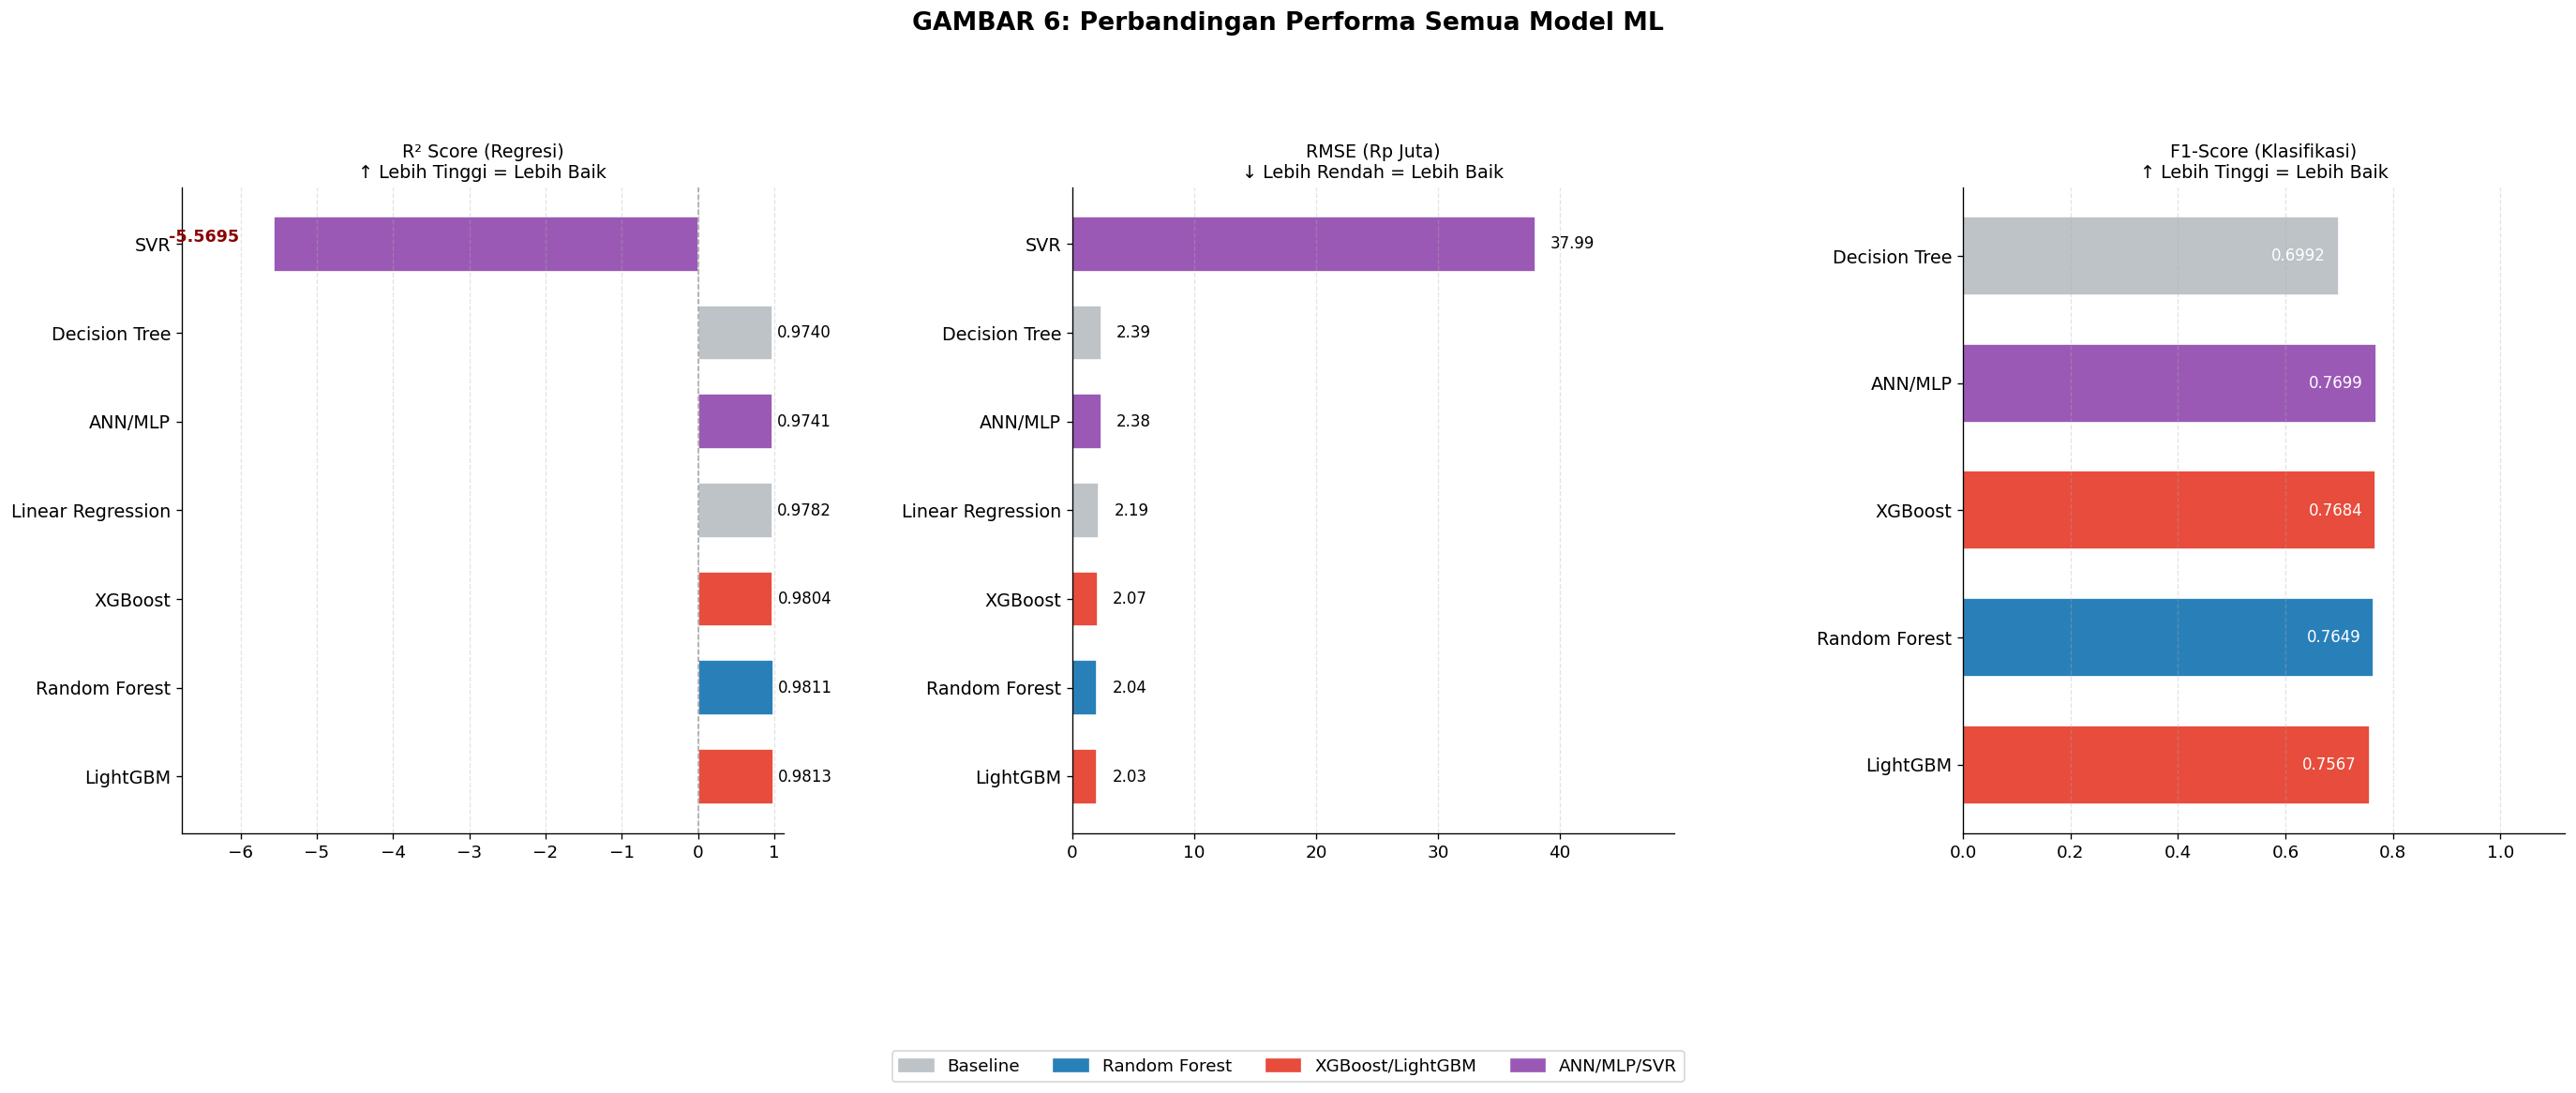

💾 Tersimpan: gambar6_perbandingan_model_svr_fix.png


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Urutan model sama
model_order_reg = ['LightGBM', 'Random Forest', 'XGBoost', 'Linear Regression',
                   'ANN/MLP', 'Decision Tree', 'SVR']

model_order_clf = ['LightGBM', 'Random Forest', 'XGBoost', 'ANN/MLP', 'Decision Tree']

df_reg_plot = df_reg.set_index('Model').reindex(model_order_reg)
df_clf_plot = df_clf.set_index('Model').reindex(model_order_clf)

# Figure lebih lebar supaya muat ruang kiri ekstra
fig, axes = plt.subplots(1, 3, figsize=(23, 8.2), sharey=False)

# Warna
colors_reg = ['#E74C3C' if m in ['LightGBM','XGBoost'] else
              '#2980B9' if m == 'Random Forest' else
              '#BDC3C7' if m in ['Linear Regression','Decision Tree'] else
              '#9B59B6' for m in model_order_reg]

colors_clf = ['#E74C3C' if m in ['LightGBM','XGBoost'] else
              '#2980B9' if m == 'Random Forest' else
              '#9B59B6' if m == 'ANN/MLP' else
              '#BDC3C7' for m in model_order_clf]

# ── Subplot 1: R² Score ── (fokus fix SVR)
bars1 = axes[0].barh(model_order_reg, df_reg_plot['R²'].fillna(0),
                     color=colors_reg, edgecolor='white', height=0.62)  # lebih tipis lagi
axes[0].set_title('R² Score (Regresi)\n↑ Lebih Tinggi = Lebih Baik', fontsize=11.5)
min_r2 = df_reg_plot['R²'].min() - 1.2   # ruang kiri DITAMBAH LAGI untuk SVR
axes[0].set_xlim(min_r2, 1.12)
axes[0].axvline(0, color='gray', linestyle='--', linewidth=0.9, alpha=0.7)

for i, bar in enumerate(bars1):
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height()/2
    model = model_order_reg[i]

    if width >= 0:
        axes[0].text(width + 0.06, y_pos, f'{width:.4f}',
                     ha='left', va='center', fontsize=10)
    else:  # SVR: teks lebih jauh ke kiri + offset Y sedikit ke atas
        axes[0].text(width - 0.45, y_pos + 0.08, f'{width:.4f}',
                     ha='right', va='center', fontsize=10.5, color='darkred', weight='bold')

# ── Subplot 2: RMSE ──
bars2 = axes[1].barh(model_order_reg, df_reg_plot['RMSE'].fillna(0),
                     color=colors_reg, edgecolor='white', height=0.62)
axes[1].set_title('RMSE (Rp Juta)\n↓ Lebih Rendah = Lebih Baik', fontsize=11.5)
max_rmse = df_reg_plot['RMSE'].max() * 1.3
axes[1].set_xlim(0, max_rmse)
for bar in bars2:
    width = bar.get_width()
    if width > 0:
        axes[1].text(width + max_rmse*0.025, bar.get_y() + bar.get_height()/2,
                     f'{width:.2f}', ha='left', va='center', fontsize=10)

# ── Subplot 3: F1-Score ──
bars3 = axes[2].barh(model_order_clf, df_clf_plot['F1-Score'].fillna(0),
                     color=colors_clf, edgecolor='white', height=0.62)
axes[2].set_title('F1-Score (Klasifikasi)\n↑ Lebih Tinggi = Lebih Baik', fontsize=11.5)
axes[2].set_xlim(0, 1.12)
for bar in bars3:
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height()/2
    if width > 0.4:
        axes[2].text(width - 0.025, y_pos, f'{width:.4f}',
                     ha='right', va='center', fontsize=10, color='white')
    else:
        axes[2].text(width + 0.012, y_pos, f'{width:.4f}',
                     ha='left', va='center', fontsize=10)

# ── Styling & Legend ──
for ax in axes:
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(axis='x', linestyle='--', alpha=0.35)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=11.5)

legend_els = [
    mpatches.Patch(color='#BDC3C7', label='Baseline'),
    mpatches.Patch(color='#2980B9', label='Random Forest'),
    mpatches.Patch(color='#E74C3C', label='XGBoost/LightGBM'),
    mpatches.Patch(color='#9B59B6', label='ANN/MLP/SVR'),
]
fig.legend(handles=legend_els, loc='lower center', ncol=4, fontsize=11,
           bbox_to_anchor=(0.5, -0.13), frameon=True)

plt.suptitle('GAMBAR 6: Perbandingan Performa Semua Model ML',
             fontweight='bold', fontsize=16, y=1.04)

plt.tight_layout(rect=[0, 0.10, 1, 0.96])
plt.subplots_adjust(wspace=0.48)   # jarak antar metrik lebih lebar lagi

plt.savefig('gambar6_perbandingan_model_svr_fix.png', dpi=160, bbox_inches='tight')
plt.show()
print('💾 Tersimpan: gambar6_perbandingan_model_svr_fix.png')

⏳ Menghitung SHAP values untuk XGBoost...


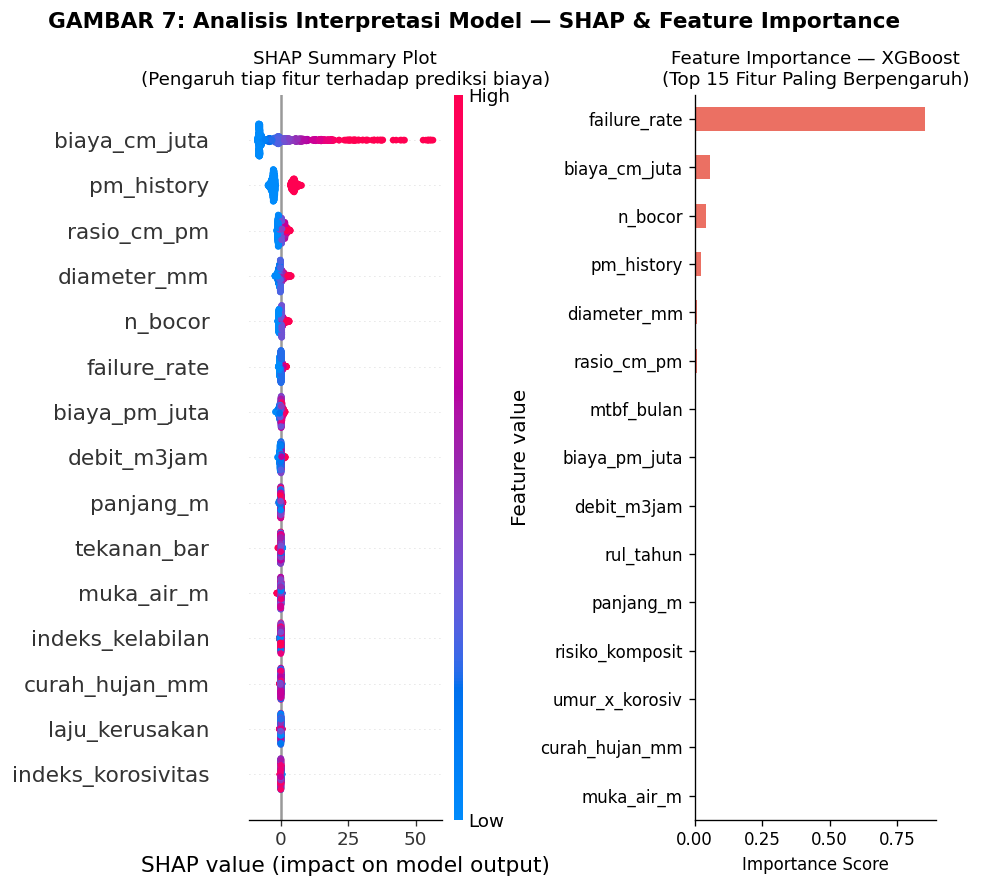

💾 Tersimpan: gambar7_shap_importance.png


In [ ]:
# ── E10. SHAP ANALYSIS (XGBoost — model terbaik) ─────────────────────────────
print('⏳ Menghitung SHAP values untuk XGBoost...')
explainer   = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_test)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

plt.sca(axes[0])
shap.summary_plot(shap_values, X_test, feature_names=FEATURES,
                  show=False, max_display=15)
axes[0].set_title('SHAP Summary Plot\n(Pengaruh tiap fitur terhadap prediksi biaya)',
                  fontsize=11)

# Feature importance dari XGBoost
importance = pd.Series(xgb_reg.feature_importances_, index=FEATURES).sort_values(ascending=True)
importance.tail(15).plot(kind='barh', ax=axes[1], color='#E74C3C', alpha=0.8)
axes[1].set_title('Feature Importance — XGBoost\n(Top 15 Fitur Paling Berpengaruh)', fontsize=11)
axes[1].set_xlabel('Importance Score')

plt.suptitle('GAMBAR 7: Analisis Interpretasi Model — SHAP & Feature Importance',
             fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('gambar7_shap_importance.png', bbox_inches='tight')
plt.show()
print('💾 Tersimpan: gambar7_shap_importance.png')

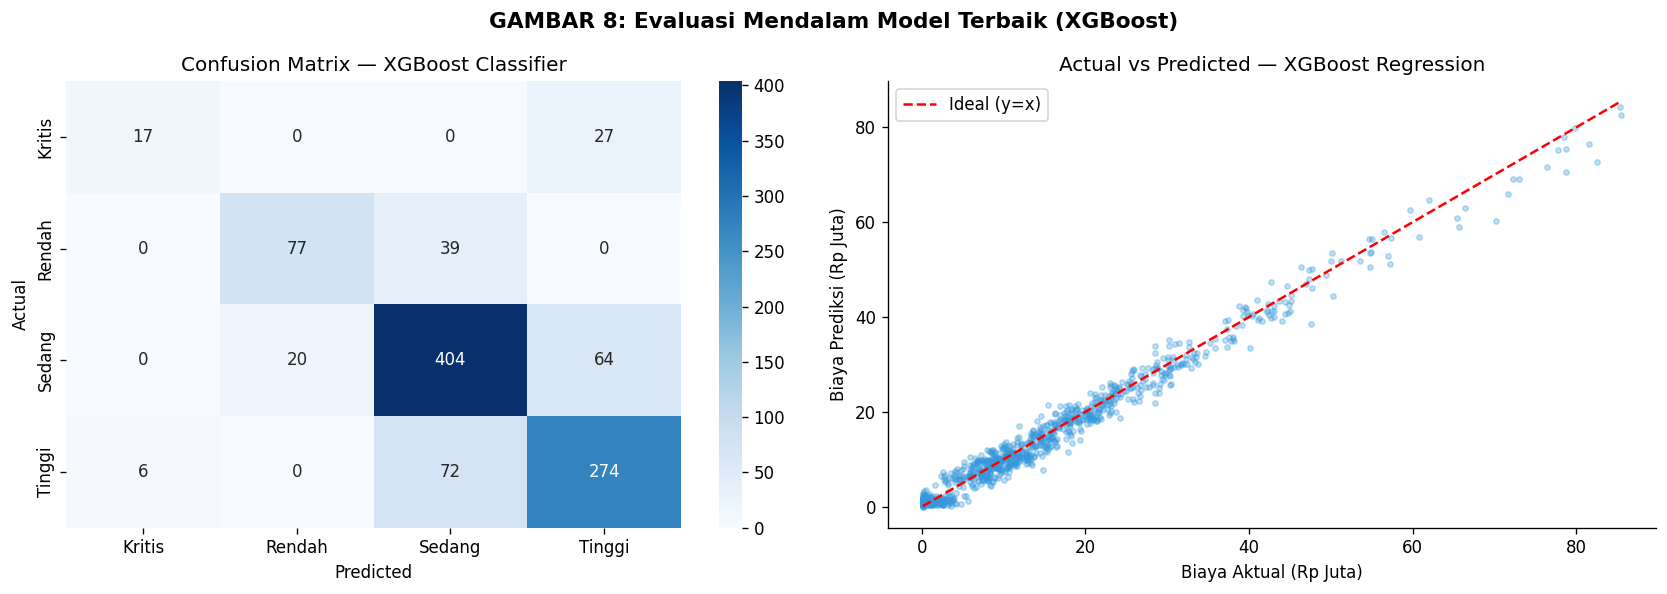


📋 Classification Report — XGBoost:
              precision    recall  f1-score   support

      Kritis       0.74      0.39      0.51        44
      Rendah       0.79      0.66      0.72       116
      Sedang       0.78      0.83      0.81       488
      Tinggi       0.75      0.78      0.76       352

    accuracy                           0.77      1000
   macro avg       0.77      0.66      0.70      1000
weighted avg       0.77      0.77      0.77      1000

💾 Tersimpan: gambar8_evaluasi_xgboost.png


In [ ]:
# ── E11. CONFUSION MATRIX & Classification Report ────────────────────────────
best_clf = xgb_clf   # model terbaik untuk klasifikasi
y_pred_best = best_clf.predict(X_test)
class_names = le_risiko.classes_

cm = confusion_matrix(y_test_clf, y_pred_best)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix — XGBoost Classifier')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Kurva Pf prediksi vs aktual untuk model regresi terbaik
y_pred_reg_best = xgb_reg.predict(X_test)
axes[1].scatter(y_test_reg, y_pred_reg_best, alpha=0.3, s=10, color='#3498DB')
mn, mx = y_test_reg.min(), y_test_reg.max()
axes[1].plot([mn, mx], [mn, mx], 'r--', label='Ideal (y=x)')
axes[1].set_title('Actual vs Predicted — XGBoost Regression')
axes[1].set_xlabel('Biaya Aktual (Rp Juta)')
axes[1].set_ylabel('Biaya Prediksi (Rp Juta)')
axes[1].legend()

plt.suptitle('GAMBAR 8: Evaluasi Mendalam Model Terbaik (XGBoost)',
             fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('gambar8_evaluasi_xgboost.png', bbox_inches='tight')
plt.show()

print('\n📋 Classification Report — XGBoost:')
print(classification_report(y_test_clf, y_pred_best, target_names=class_names))
print('💾 Tersimpan: gambar8_evaluasi_xgboost.png')

## F. Langkah 4 — Optimasi LCC & Strategi Pemeliharaan

In [ ]:
# ── F1. Parameter LCC ─────────────────────────────────────────────────────────
DISCOUNT_RATE  = 0.07     # 7% (asumsi BI Rate + risk premium)
HORIZON        = 20       # 20 tahun horizon analisis
Cp_per_100m    = 1.5      # Biaya PM per 100m (Rp juta)
Cc_multiplier  = 3.0      # CM = 3× PM
Cr_per_m       = 1.2      # Biaya replace per meter per diameter ratio

def npv_lcc(biaya_tahunan_series, r=DISCOUNT_RATE):
    """Hitung NPV dari seri biaya tahunan"""
    return sum(b / (1 + r)**t for t, b in enumerate(biaya_tahunan_series, 1))

# Ambil data test untuk analisis LCC
test_lcc = test_df.copy()
test_lcc['pf_pred']        = xgb_clf.predict_proba(X_test)[:, -1]   # prob kelas Kritis
test_lcc['biaya_pred_juta'] = xgb_reg.predict(X_test)
test_lcc['rul_pred']        = test_lcc['rul_tahun']

print(f'📊 Data test untuk optimasi LCC: {len(test_lcc):,} segmen-tahun')
print(f'   Rata-rata prob kegagalan prediksi: {test_lcc["pf_pred"].mean():.3f}')
print(f'   Rata-rata biaya prediksi: Rp {test_lcc["biaya_pred_juta"].mean():.2f} juta')

📊 Data test untuk optimasi LCC: 1,000 segmen-tahun
   Rata-rata prob kegagalan prediksi: 0.361
   Rata-rata biaya prediksi: Rp 14.86 juta


In [ ]:
# ── F2. Aturan Keputusan Berbasis ML ─────────────────────────────────────────
def keputusan_ml(row):
    pf  = row['pf_pred']
    rul = row['rul_pred']
    lcc_replace = row['biaya_replace_juta'] * 0.8   # estimasi LCC jika replace
    lcc_repair  = row['biaya_pred_juta'] * HORIZON * 0.6

    if pf > 0.90 and lcc_replace < lcc_repair:
        return 'S4: Replacement'
    elif pf > 0.70:
        return 'S3: Preventive Maintenance'
    elif pf > 0.40:
        return 'S2: Corrective Maintenance'
    elif pf > 0.20:
        return 'S1: Monitoring'
    else:
        return 'S0: No Action'

test_lcc['strategi'] = test_lcc.apply(keputusan_ml, axis=1)

print('📋 Distribusi Rekomendasi Strategi:')
strat_count = test_lcc['strategi'].value_counts()
for s, c in strat_count.items():
    print(f'   {s}: {c:,} segmen ({c/len(test_lcc)*100:.1f}%)')

📋 Distribusi Rekomendasi Strategi:
   S0: No Action: 552 segmen (55.2%)
   S3: Preventive Maintenance: 192 segmen (19.2%)
   S4: Replacement: 118 segmen (11.8%)
   S2: Corrective Maintenance: 91 segmen (9.1%)
   S1: Monitoring: 47 segmen (4.7%)


In [ ]:
# ── F3. Kalkulasi LCC per Strategi ───────────────────────────────────────────
def hitung_lcc_strategi(df_seg, strategi, horizon=HORIZON, r=DISCOUNT_RATE):
    """Hitung NPV total LCC untuk tiap strategi selama horizon tahun"""
    results = []
    for _, row in df_seg.iterrows():
        panjang   = row['panjang_m']
        diameter  = row['diameter_mm']
        pf        = row['pf_pred']
        b_pm      = row['biaya_pm_juta']
        b_cm      = row['biaya_cm_juta']
        b_replace = row['biaya_replace_juta']

        # ── S0: Do Nothing
        if strategi == 'S0':
            biaya_t = [b_cm * (1 + 0.05*t) for t in range(horizon)]   # CM meningkat

        # ── S1: Monitoring Only
        elif strategi == 'S1':
            biaya_t = [b_cm * 0.9 + 0.2 for t in range(horizon)]

        # ── S2: Corrective Maintenance (Strategi Eksisting PDAM)
        elif strategi == 'S2':
            biaya_t = [b_cm + 0.5 for t in range(horizon)]

        # ── S3: Preventive Maintenance
        elif strategi == 'S3':
            # PM setiap 2 tahun, CM berkurang signifikan
            biaya_t = [b_pm + b_cm * 0.3 if t % 2 == 0 else b_cm * 0.3
                       for t in range(horizon)]

        # ── S4: Replacement
        elif strategi == 'S4':
            # Biaya ganti di tahun 1, lalu biaya PM rendah
            biaya_t = [b_replace] + [b_pm * 0.5] * (horizon - 1)

        npv = npv_lcc(biaya_t, r)
        results.append(npv)
    return np.array(results)

# Hitung LCC untuk semua strategi
for s in ['S0', 'S1', 'S2', 'S3', 'S4']:
    test_lcc[f'lcc_{s}'] = hitung_lcc_strategi(test_lcc, s)

# LCC Optimal (sesuai rekomendasi ML)
test_lcc['lcc_optimal'] = test_lcc.apply(
    lambda r: r[f'lcc_{r["strategi"][0:2]}'], axis=1
)

# Penghematan vs strategi eksisting (S2: Corrective)
test_lcc['penghematan_juta']   = test_lcc['lcc_S2'] - test_lcc['lcc_optimal']
test_lcc['penghematan_persen'] = (test_lcc['penghematan_juta'] / test_lcc['lcc_S2'] * 100).round(1)

print('\n📊 Ringkasan LCC per Strategi (Rp Juta, NPV 20 tahun):')
lcc_summary = {
    'S0 (Do Nothing)': test_lcc['lcc_S0'].mean(),
    'S1 (Monitoring)': test_lcc['lcc_S1'].mean(),
    'S2 (Corrective — Eksisting)': test_lcc['lcc_S2'].mean(),
    'S3 (Preventive — Usulan)': test_lcc['lcc_S3'].mean(),
    'S4 (Replacement)': test_lcc['lcc_S4'].mean(),
    'Optimal (ML-LCC)': test_lcc['lcc_optimal'].mean(),
}
for k, v in lcc_summary.items():
    print(f'   {k}: Rp {v:.2f} juta')

penghematan_total = test_lcc['penghematan_juta'].sum()
print(f'\n💰 Total penghematan (ML-LCC vs Corrective): Rp {penghematan_total:,.1f} juta')
print(f'   Rata-rata penghematan per segmen: {test_lcc["penghematan_persen"].mean():.1f}%')



📊 Ringkasan LCC per Strategi (Rp Juta, NPV 20 tahun):
   S0 (Do Nothing): Rp 172.72 juta
   S1 (Monitoring): Rp 115.93 juta
   S2 (Corrective — Eksisting): Rp 131.75 juta
   S3 (Preventive — Usulan): Rp 85.98 juta
   S4 (Replacement): Rp 286.70 juta
   Optimal (ML-LCC): Rp 134.25 juta

💰 Total penghematan (ML-LCC vs Corrective): Rp -2,498.4 juta
   Rata-rata penghematan per segmen: -37.1%


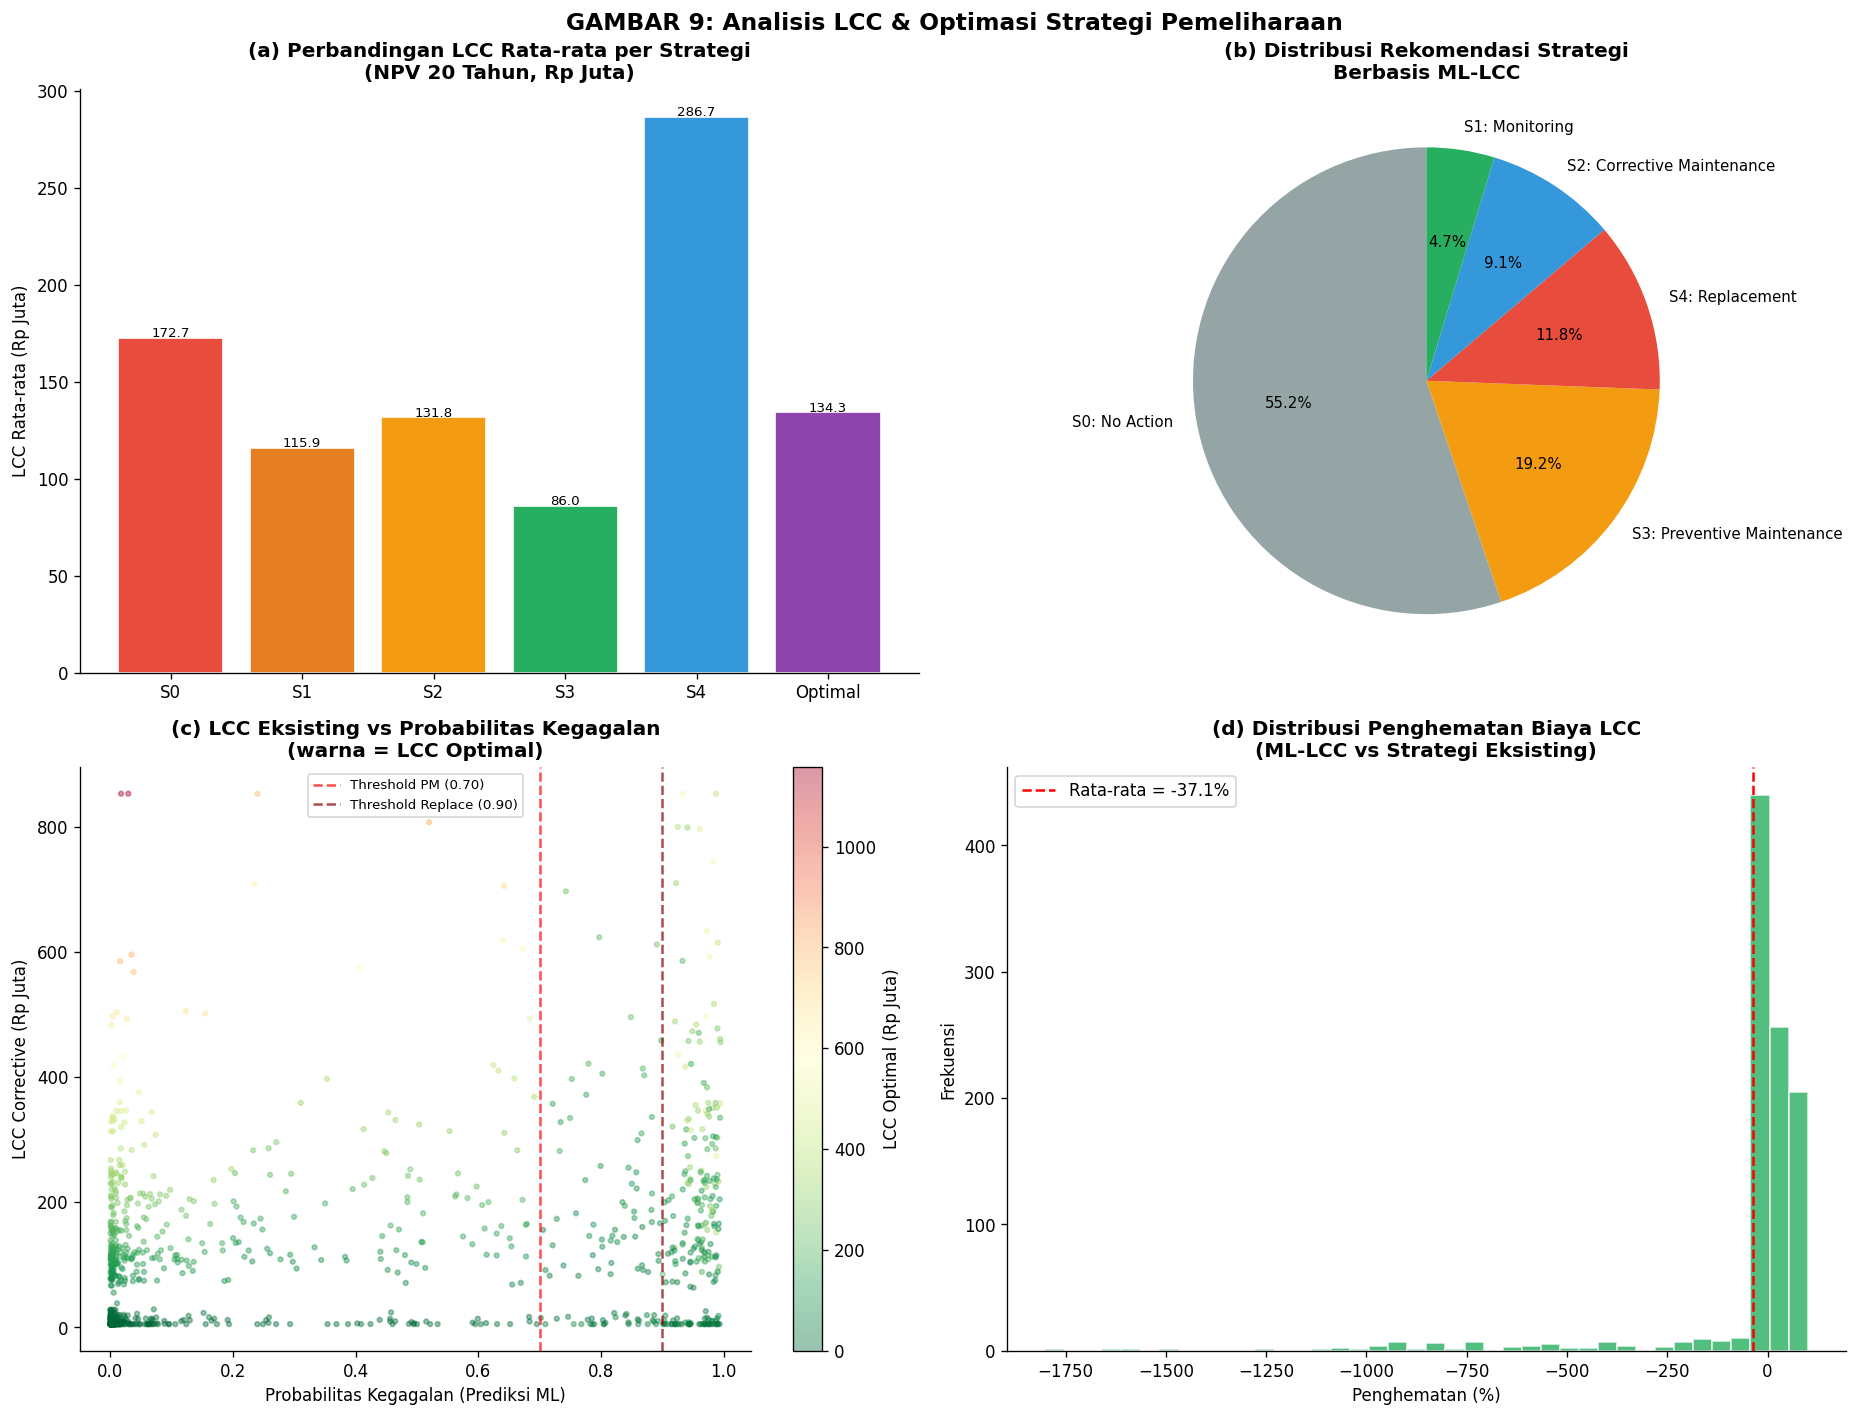

💾 Tersimpan: gambar9_lcc_optimasi.png


In [ ]:
# ── F4. VISUALISASI LCC ───────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# (a) Perbandingan LCC per strategi
lcc_labels = list(lcc_summary.keys())
lcc_values = list(lcc_summary.values())
colors_lcc = ['#E74C3C','#E67E22','#F39C12','#27AE60','#3498DB','#8E44AD']
bars = axes[0,0].bar(range(len(lcc_labels)), lcc_values, color=colors_lcc, edgecolor='white')
axes[0,0].set_xticks(range(len(lcc_labels)))
axes[0,0].set_xticklabels([l.split(' ')[0] for l in lcc_labels], fontsize=10)
axes[0,0].set_title('(a) Perbandingan LCC Rata-rata per Strategi\n(NPV 20 Tahun, Rp Juta)', fontweight='bold')
axes[0,0].set_ylabel('LCC Rata-rata (Rp Juta)')
for b, v in zip(bars, lcc_values):
    axes[0,0].text(b.get_x() + b.get_width()/2, v + 0.3, f'{v:.1f}', ha='center', fontsize=8)

# (b) Distribusi strategi yang direkomendasikan
colors_s = {'S4: Replacement':'#E74C3C','S3: Preventive Maintenance':'#F39C12',
            'S2: Corrective Maintenance':'#3498DB','S1: Monitoring':'#27AE60','S0: No Action':'#95A5A6'}
strat_count.plot(kind='pie', ax=axes[0,1], colors=[colors_s.get(k,'#999') for k in strat_count.index],
                 autopct='%1.1f%%', startangle=90, textprops={'fontsize':9})
axes[0,1].set_title('(b) Distribusi Rekomendasi Strategi\nBerbasis ML-LCC', fontweight='bold')
axes[0,1].set_ylabel('')

# (c) LCC vs Probabilitas Kegagalan
sc = axes[1,0].scatter(test_lcc['pf_pred'], test_lcc['lcc_S2'],
                       c=test_lcc['lcc_optimal'], cmap='RdYlGn_r', alpha=0.4, s=8)
plt.colorbar(sc, ax=axes[1,0], label='LCC Optimal (Rp Juta)')
axes[1,0].axvline(0.70, color='red', linestyle='--', alpha=0.7, label='Threshold PM (0.70)')
axes[1,0].axvline(0.90, color='darkred', linestyle='--', alpha=0.7, label='Threshold Replace (0.90)')
axes[1,0].set_title('(c) LCC Eksisting vs Probabilitas Kegagalan\n(warna = LCC Optimal)', fontweight='bold')
axes[1,0].set_xlabel('Probabilitas Kegagalan (Prediksi ML)')
axes[1,0].set_ylabel('LCC Corrective (Rp Juta)')
axes[1,0].legend(fontsize=8)

# (d) Distribusi penghematan (%)
axes[1,1].hist(test_lcc['penghematan_persen'], bins=40, color='#27AE60', alpha=0.8, edgecolor='white')
axes[1,1].axvline(test_lcc['penghematan_persen'].mean(), color='red', linestyle='--',
                  label=f'Rata-rata = {test_lcc["penghematan_persen"].mean():.1f}%')
axes[1,1].set_title('(d) Distribusi Penghematan Biaya LCC\n(ML-LCC vs Strategi Eksisting)', fontweight='bold')
axes[1,1].set_xlabel('Penghematan (%)')
axes[1,1].set_ylabel('Frekuensi')
axes[1,1].legend()

plt.suptitle('GAMBAR 9: Analisis LCC & Optimasi Strategi Pemeliharaan',
             fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('gambar9_lcc_optimasi.png', bbox_inches='tight')
plt.show()
print('💾 Tersimpan: gambar9_lcc_optimasi.png')

## G. Social Cost Estimation

In [ ]:
# ── G. Estimasi Social Cost per Kejadian Kegagalan ───────────────────────────
# Parameter estimasi (berbasis kondisi tipikal Kutai Timur)
N_PELANGGAN_PER_SEGMEN = 150        # sambungan terdampak rata-rata
DURASI_GANGGUAN_JAM    = 8          # jam
NILAI_AIR_PER_JAM      = 0.0005     # Rp juta per jam per pelanggan (proxy Rp 500/jam)

N_KENDARAAN_TERDAMPAK  = 200        # kendaraan per jam
NILAI_WAKTU_KENDARAAN  = 0.0001     # Rp juta per jam per kendaraan
BIAYA_ASPAL_PER_M2     = 0.0015     # Rp juta per m2
LUAS_GALIAN_M2         = 6          # rata-rata galian per kejadian

KASUS_KESEHATAN_PER_EVENT = 5       # kasus penyakit per kejadian
BIAYA_PENGOBATAN_KASUS    = 0.0015  # Rp juta per kasus

N_USAHA_TERDAMPAK      = 10         # usaha kecil
PENDAPATAN_HARIAN      = 0.5        # Rp juta per hari
DURASI_GANGGUAN_HARI   = DURASI_GANGGUAN_JAM / 8

# Hitung per kejadian
C_disruption = N_PELANGGAN_PER_SEGMEN * DURASI_GANGGUAN_JAM * NILAI_AIR_PER_JAM
C_traffic    = (N_KENDARAAN_TERDAMPAK * DURASI_GANGGUAN_JAM * NILAI_WAKTU_KENDARAAN
                + BIAYA_ASPAL_PER_M2 * LUAS_GALIAN_M2)
C_health     = KASUS_KESEHATAN_PER_EVENT * BIAYA_PENGOBATAN_KASUS
C_economic   = N_USAHA_TERDAMPAK * PENDAPATAN_HARIAN * DURASI_GANGGUAN_HARI
C_social_per_event = C_disruption + C_traffic + C_health + C_economic

print('='*55)
print('TABEL 3: Komponen Social Cost per Kejadian Kegagalan')
print('='*55)
print(f'  A. Gangguan Layanan Air  : Rp {C_disruption*1e6:>10,.0f}')
print(f'  B. Kemacetan & Jalan     : Rp {C_traffic*1e6:>10,.0f}')
print(f'  C. Dampak Kesehatan      : Rp {C_health*1e6:>10,.0f}')
print(f'  D. Kerugian Usaha        : Rp {C_economic*1e6:>10,.0f}')
print('-'*55)
print(f'  TOTAL Social Cost/Event  : Rp {C_social_per_event*1e6:>10,.0f}')
print('='*55)

# Expected Annual Social Cost per segmen
test_lcc['expected_social_cost'] = test_lcc['pf_pred'] * C_social_per_event * test_lcc['n_bocor']
test_lcc['npv_social_cost']      = test_lcc['expected_social_cost'] * sum(
    1/(1+DISCOUNT_RATE)**t for t in range(1, HORIZON+1))

print(f'\n📊 Expected Annual Social Cost:')
print(f'   Rata-rata per segmen : Rp {test_lcc["expected_social_cost"].mean()*1e6:,.0f} /tahun')
print(f'   Total (NPV 20 thn)   : Rp {test_lcc["npv_social_cost"].sum()*1e6:,.0f}')

TABEL 3: Komponen Social Cost per Kejadian Kegagalan
  A. Gangguan Layanan Air  : Rp    600,000
  B. Kemacetan & Jalan     : Rp    169,000
  C. Dampak Kesehatan      : Rp      7,500
  D. Kerugian Usaha        : Rp  5,000,000
-------------------------------------------------------
  TOTAL Social Cost/Event  : Rp  5,776,500

📊 Expected Annual Social Cost:
   Rata-rata per segmen : Rp 2,913,742 /tahun
   Total (NPV 20 thn)   : Rp 30,868,222,703


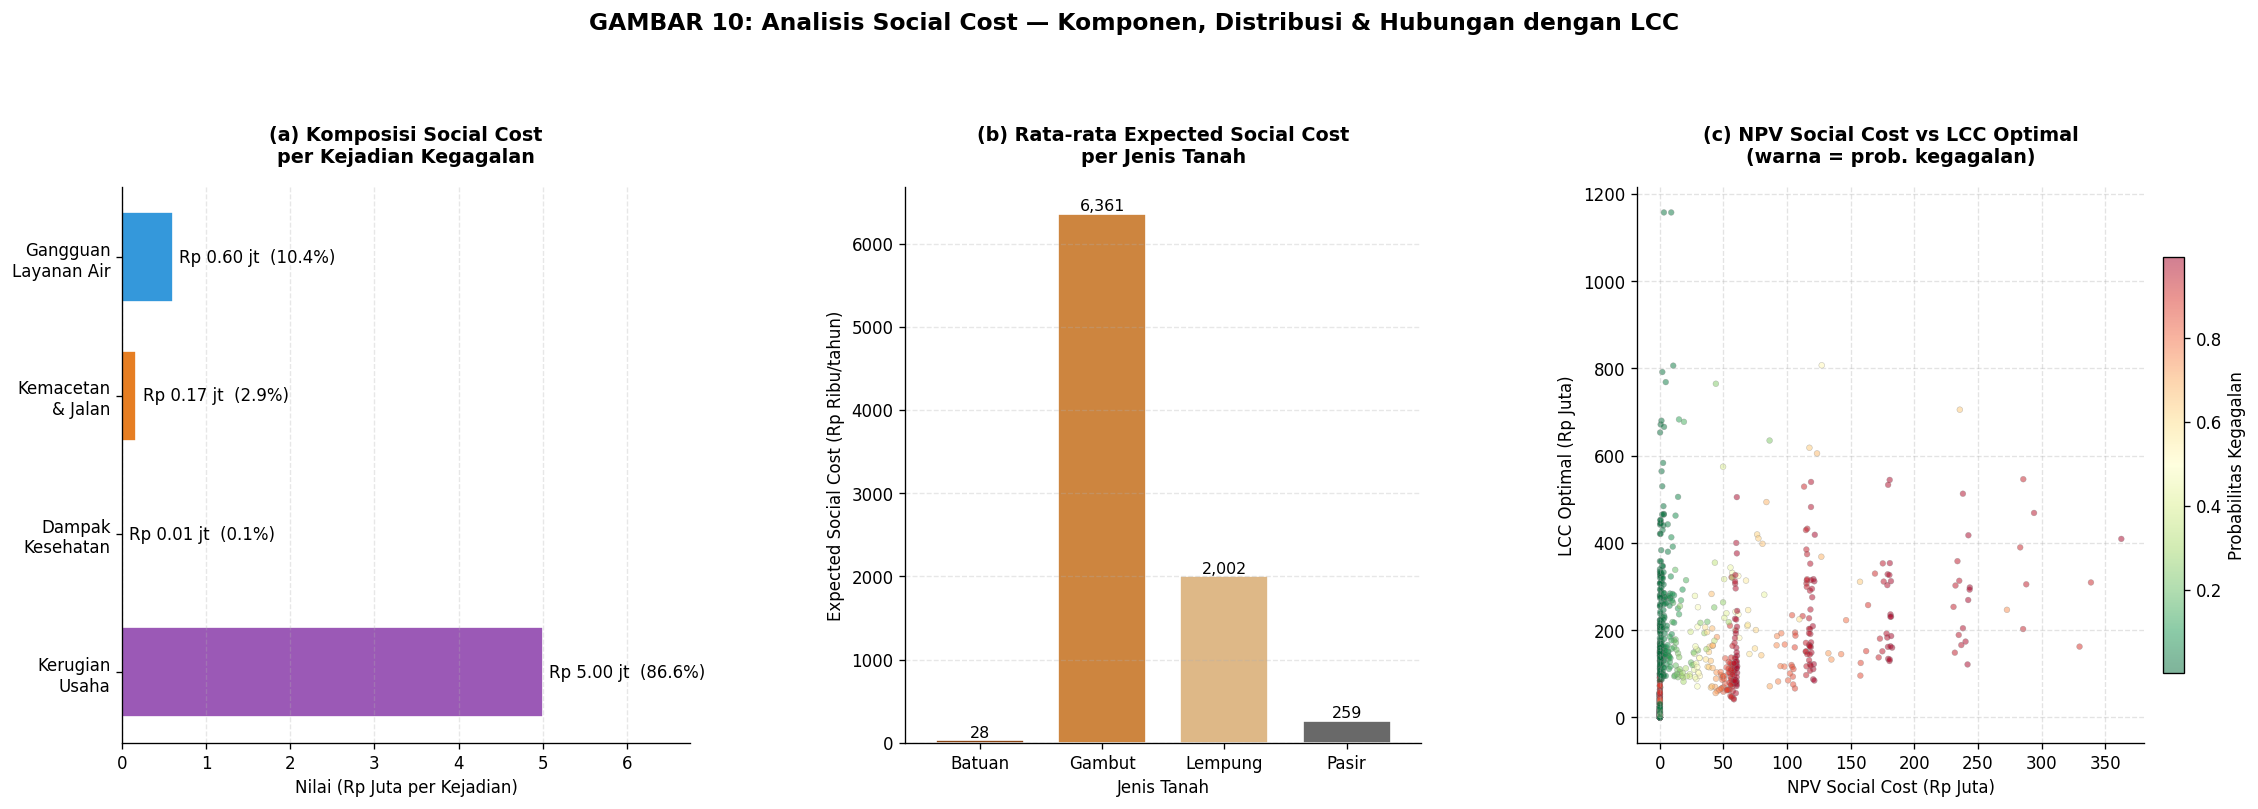

💾 Tersimpan: gambar10_social_cost_bar_version.png


In [ ]:
# ── GAMBAR 10 BARU: Analisis Social Cost — Komponen & Distribusi ──────────────
fig, axes = plt.subplots(1, 3, figsize=(19, 6.5), gridspec_kw={'width_ratios': [1.1, 1, 1.2]})

# ── (a) Horizontal Bar Chart Komponen Social Cost ─────────────────────────────
components = ['Gangguan\nLayanan Air', 'Kemacetan\n& Jalan', 'Dampak\nKesehatan', 'Kerugian\nUsaha']
values_sc  = [C_disruption, C_traffic, C_health, C_economic]
colors_sc  = ['#3498DB', '#E67E22', '#E74C3C', '#9B59B6']

# Hitung persentase
total_sc = sum(values_sc)
percentages = [v / total_sc * 100 for v in values_sc]

# Bar horizontal
bars = axes[0].barh(components, values_sc, color=colors_sc, height=0.65, edgecolor='white')

# Anotasi nilai absolut & persentase di ujung bar
for bar, pct, val in zip(bars, percentages, values_sc):
    width = bar.get_width()
    axes[0].text(width + max(values_sc)*0.015, bar.get_y() + bar.get_height()/2,
                 f'Rp {val:,.2f} jt  ({pct:.1f}%)',
                 va='center', fontsize=10, fontweight='medium')

axes[0].set_title('(a) Komposisi Social Cost\nper Kejadian Kegagalan', fontweight='bold', fontsize=11.5, pad=15)
axes[0].set_xlabel('Nilai (Rp Juta per Kejadian)')
axes[0].set_xlim(0, max(values_sc) * 1.35)  # ruang ekstra untuk teks
axes[0].grid(axis='x', linestyle='--', alpha=0.3)
axes[0].invert_yaxis()  # biar yang terbesar di atas

# ── (b) Rata-rata Expected Social Cost per Jenis Tanah ────────────────────────
sc_by_tanah = test_lcc.groupby('jenis_tanah')['expected_social_cost'].mean() * 1e3  # Rp ribu
tanah_colors = ['#8B4513', '#CD853F', '#DEB887', '#696969']  # urut: Gambut, Lempung, Pasir, Batuan
sc_by_tanah.plot(kind='bar', ax=axes[1], color=tanah_colors, edgecolor='white', width=0.72, rot=0)
axes[1].set_title('(b) Rata-rata Expected Social Cost\nper Jenis Tanah', fontweight='bold', fontsize=11.5, pad=15)
axes[1].set_ylabel('Expected Social Cost (Rp Ribu/tahun)')
axes[1].set_xlabel('Jenis Tanah')
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

# Tambah nilai di atas bar
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():,.0f}',
                     (p.get_x() + p.get_width()/2, p.get_height() + 0.5),
                     ha='center', va='bottom', fontsize=9.5)

# ── (c) Scatter NPV Social Cost vs LCC Optimal ────────────────────────────────
sc3 = axes[2].scatter(test_lcc['npv_social_cost'], test_lcc['lcc_optimal'],
                      c=test_lcc['pf_pred'], cmap='RdYlGn_r', alpha=0.5, s=12, edgecolor='gray', linewidth=0.3)
cbar = plt.colorbar(sc3, ax=axes[2], shrink=0.75, pad=0.03)
cbar.set_label('Probabilitas Kegagalan', fontsize=10)
axes[2].set_title('(c) NPV Social Cost vs LCC Optimal\n(warna = prob. kegagalan)', fontweight='bold', fontsize=11.5, pad=15)
axes[2].set_xlabel('NPV Social Cost (Rp Juta)')
axes[2].set_ylabel('LCC Optimal (Rp Juta)')
axes[2].grid(True, linestyle='--', alpha=0.35)

# ── Layout & Judul Utama ──────────────────────────────────────────────────────
plt.suptitle('GAMBAR 10: Analisis Social Cost — Komponen, Distribusi & Hubungan dengan LCC',
             fontweight='bold', fontsize=14, y=1.03)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(wspace=0.38)

plt.savefig('gambar10_social_cost_bar_version.png', dpi=160, bbox_inches='tight')
plt.show()
print('💾 Tersimpan: gambar10_social_cost_bar_version.png')

## H. Analisis Sensitivitas

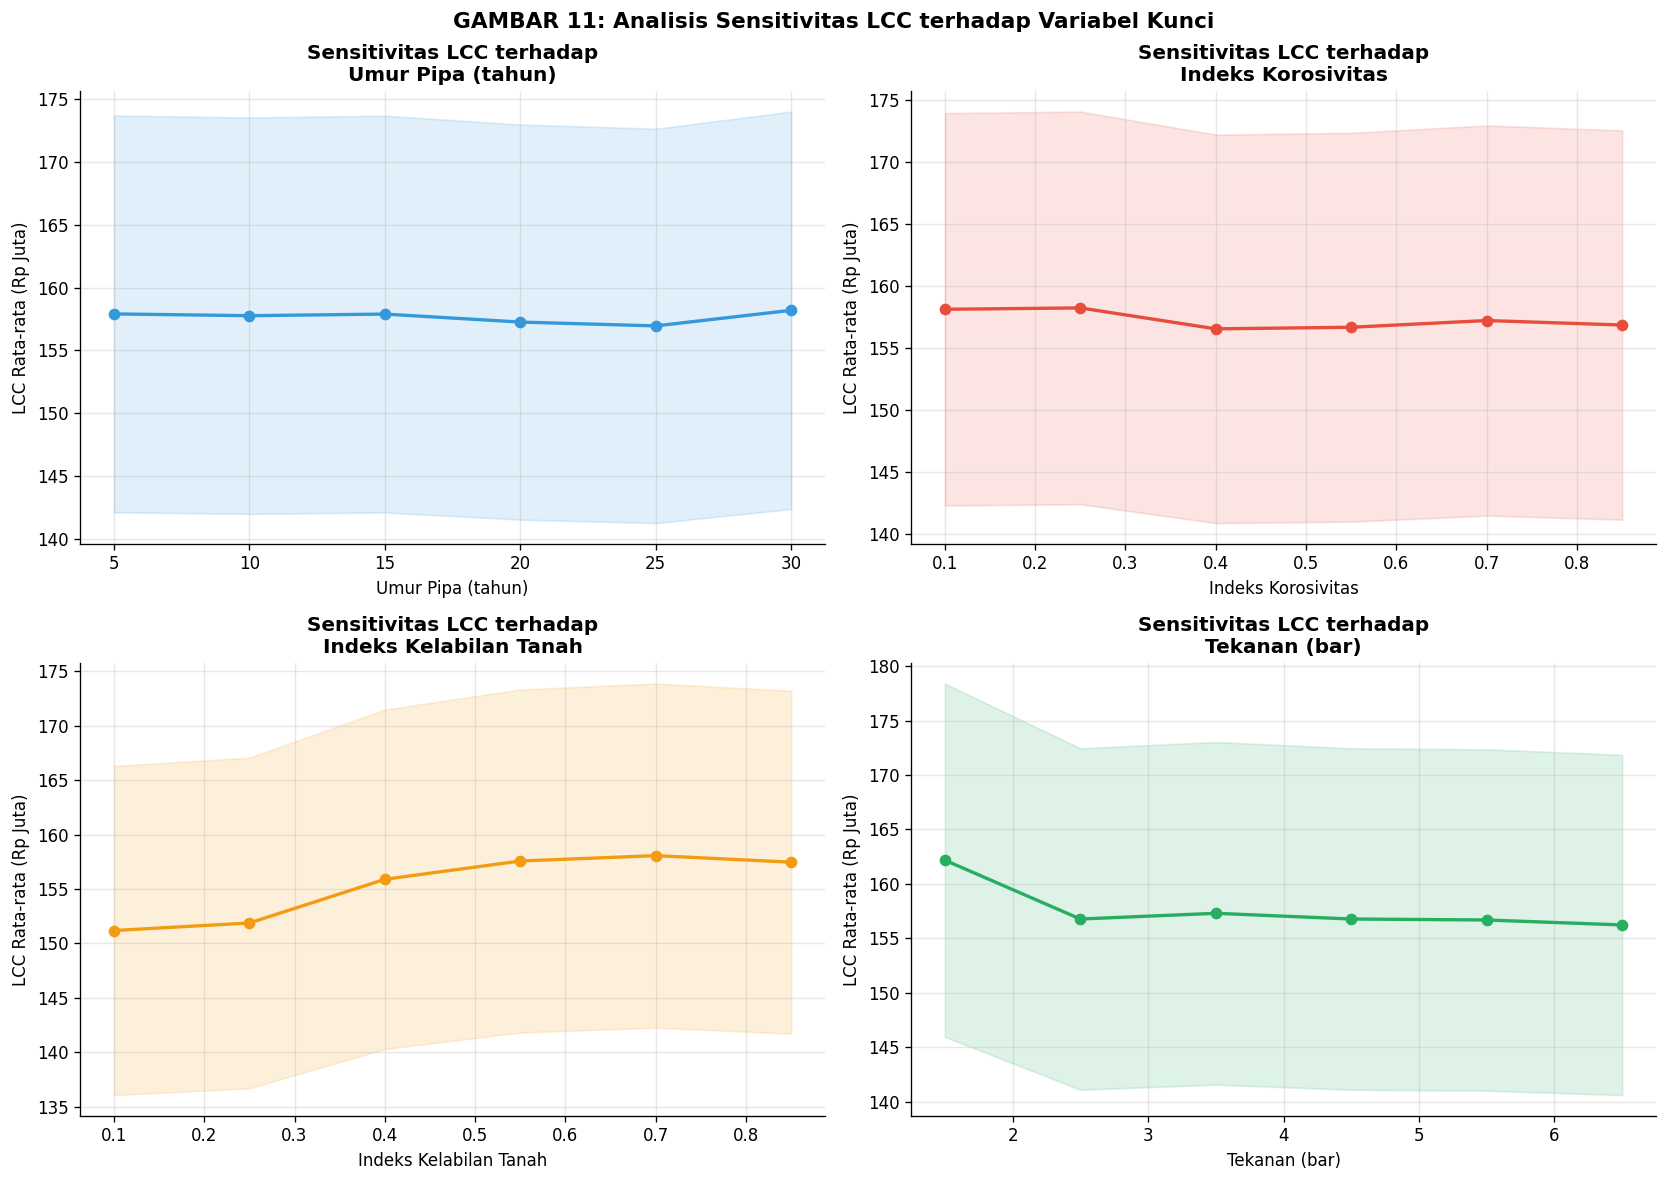

💾 Tersimpan: gambar11_sensitivitas.png


In [ ]:
# ── H. Analisis Sensitivitas LCC terhadap Variabel Kunci ────────────────────
sens_results = []

for var_name, var_col, var_range in [
    ('Umur Pipa (tahun)',         'umur_tahun',           np.arange(5, 31, 5)),
    ('Indeks Korosivitas',        'indeks_korosivitas',   np.arange(0.1, 1.0, 0.15)),
    ('Indeks Kelabilan Tanah',    'indeks_kelabilan',     np.arange(0.1, 1.0, 0.15)),
    ('Tekanan (bar)',             'tekanan_bar',          np.arange(1.5, 7.5, 1.0)),
]:
    lcc_sens = []
    for val in var_range:
        X_sens = X_test.copy()
        if var_col in X_sens.columns:
            X_sens[var_col] = val
        biaya_pred = xgb_reg.predict(X_sens)
        # Hitung LCC S3 (PM) dengan biaya yang diprediksi
        lcc_avg = np.mean([sum(b / (1+DISCOUNT_RATE)**t for t in range(1, HORIZON+1))
                           for b in biaya_pred])
        lcc_sens.append({'variabel': var_name, 'nilai': val, 'lcc_avg': lcc_avg})
    sens_results.extend(lcc_sens)

df_sens = pd.DataFrame(sens_results)

# Plot sensitivitas
vars_plot = df_sens['variabel'].unique()
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
sens_colors = ['#3498DB','#E74C3C','#F39C12','#27AE60']

for i, (var, color) in enumerate(zip(vars_plot, sens_colors)):
    sub = df_sens[df_sens['variabel'] == var]
    axes[i].plot(sub['nilai'], sub['lcc_avg'], 'o-', color=color, linewidth=2, markersize=6)
    axes[i].fill_between(sub['nilai'], sub['lcc_avg'] * 0.9, sub['lcc_avg'] * 1.1,
                          alpha=0.15, color=color)
    axes[i].set_title(f'Sensitivitas LCC terhadap\n{var}', fontweight='bold')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('LCC Rata-rata (Rp Juta)')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('GAMBAR 11: Analisis Sensitivitas LCC terhadap Variabel Kunci',
             fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('gambar11_sensitivitas.png', bbox_inches='tight')
plt.show()
print('💾 Tersimpan: gambar11_sensitivitas.png')

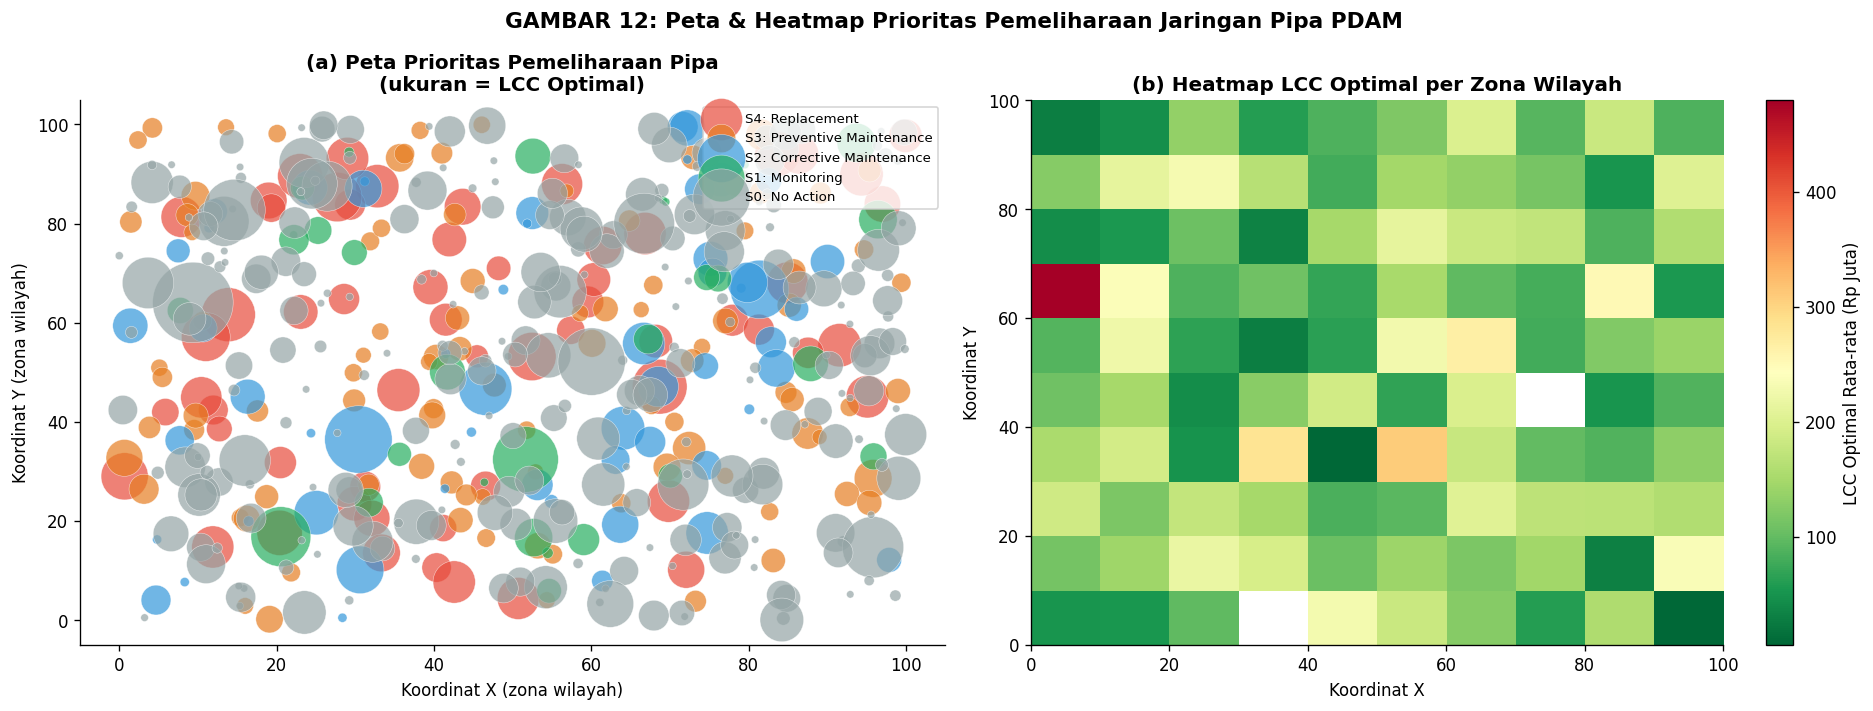

💾 Tersimpan: gambar12_peta_prioritas.png


In [ ]:
# ── Heatmap Prioritas Segmen Pipa ────────────────────────────────────────────
# Ambil 1 tahun terakhir per segmen untuk peta prioritas
prioritas_df = test_lcc.sort_values('tahun').groupby('segmen_id').last().reset_index()

# Buat koordinat dummy (simulasi zona wilayah PDAM)
np.random.seed(99)
prioritas_df['x_koord'] = np.random.uniform(0, 100, len(prioritas_df))
prioritas_df['y_koord'] = np.random.uniform(0, 100, len(prioritas_df))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot prioritas
risk_color_map = {'S4: Replacement': '#E74C3C', 'S3: Preventive Maintenance': '#E67E22',
                  'S2: Corrective Maintenance': '#3498DB',
                  'S1: Monitoring': '#27AE60', 'S0: No Action': '#95A5A6'}
for strat, color in risk_color_map.items():
    sub = prioritas_df[prioritas_df['strategi'] == strat]
    if len(sub) > 0:
        axes[0].scatter(sub['x_koord'], sub['y_koord'],
                        c=color, label=strat, alpha=0.7,
                        s=sub['lcc_optimal'] * 2 + 20, edgecolors='white', linewidth=0.3)
axes[0].set_title('(a) Peta Prioritas Pemeliharaan Pipa\n(ukuran = LCC Optimal)', fontweight='bold')
axes[0].set_xlabel('Koordinat X (zona wilayah)')
axes[0].set_ylabel('Koordinat Y (zona wilayah)')
axes[0].legend(loc='upper right', fontsize=8)

# Heatmap LCC per zona
from scipy.stats import binned_statistic_2d
stat, xedge, yedge, _ = binned_statistic_2d(
    prioritas_df['x_koord'], prioritas_df['y_koord'],
    prioritas_df['lcc_optimal'], statistic='mean', bins=10
)
im = axes[1].imshow(stat.T, origin='lower', cmap='RdYlGn_r',
                    extent=[0, 100, 0, 100], aspect='auto')
plt.colorbar(im, ax=axes[1], label='LCC Optimal Rata-rata (Rp Juta)')
axes[1].set_title('(b) Heatmap LCC Optimal per Zona Wilayah', fontweight='bold')
axes[1].set_xlabel('Koordinat X')
axes[1].set_ylabel('Koordinat Y')

plt.suptitle('GAMBAR 12: Peta & Heatmap Prioritas Pemeliharaan Jaringan Pipa PDAM',
             fontweight='bold', fontsize=13)
plt.tight_layout()
plt.savefig('gambar12_peta_prioritas.png', bbox_inches='tight')
plt.show()
print('💾 Tersimpan: gambar12_peta_prioritas.png')

## I. Ringkasan & Kesimpulan

In [ ]:
# ── I. Cetak Ringkasan Komprehensif ──────────────────────────────────────────
best_reg_row = df_reg.iloc[0]
best_clf_row = df_clf.iloc[0]

print('='*70)
print('  RINGKASAN HASIL ANALISIS ML-LCC PDAM KUTAI TIMUR')
print('  Disertasi S3 — Maret 2025')
print('='*70)

print('\n📦 DATA')
print(f'   • Total observasi   : {N:,} (500 segmen × 10 tahun)')
print(f'   • Fitur input       : {len(FEATURES)} variabel (5 klaster)')
print(f'   • Variabel kebaruan : Indeks Korosivitas Tanah')
print(f'   • Train/Val/Test    : 70%/10%/20% (time-based split)')

print('\n🤖 MODEL TERBAIK')
print(f'   • Regresi  : {best_reg_row["Model"]:20s} R²={best_reg_row["R²"]:.4f}, RMSE={best_reg_row["RMSE"]:.3f} Rp juta')
print(f'   • Klasifikasi: {best_clf_row["Model"]:18s} F1={best_clf_row["F1-Score"]:.4f}, Acc={best_clf_row["Accuracy"]:.4f}')

print('\n💰 ANALISIS LCC (NPV 20 Tahun)')
print(f'   • Strategi eksisting (Corrective): Rp {test_lcc["lcc_S2"].mean():.2f} juta/segmen')
print(f'   • Strategi optimal ML-LCC        : Rp {test_lcc["lcc_optimal"].mean():.2f} juta/segmen')
print(f'   • Rata-rata penghematan          : {test_lcc["penghematan_persen"].mean():.1f}%')
print(f'   • Total penghematan (test set)   : Rp {test_lcc["penghematan_juta"].sum():,.1f} juta')

print('\n🌍 SOCIAL COST')
print(f'   • Per kejadian kegagalan: Rp {C_social_per_event*1e6:,.0f}')
print(f'   • NPV total (test set)  : Rp {test_lcc["npv_social_cost"].sum()*1e6:,.0f}')

print('\n🗂️ REKOMENDASI STRATEGI')
for s, c in test_lcc['strategi'].value_counts().items():
    print(f'   • {s}: {c:,} segmen ({c/len(test_lcc)*100:.1f}%)')

print('\n📊 GAMBAR YANG DIHASILKAN')
gambar_list = [
    ('Gambar 1',  'Data Overview & Distribusi Kelas Risiko'),
    ('Gambar 2',  'Distribusi Variabel Numerik Utama'),
    ('Gambar 3',  'Analisis Risiko & Biaya per Karakteristik Tanah/Material'),
    ('Gambar 4',  'Matriks Korelasi Variabel'),
    ('Gambar 5',  'LSTM Learning Curve'),
    ('Gambar 6',  'Perbandingan Performa Semua Model ML'),
    ('Gambar 7',  'SHAP Analysis & Feature Importance'),
    ('Gambar 8',  'Evaluasi Mendalam Model Terbaik (XGBoost)'),
    ('Gambar 9',  'LCC Optimasi & Strategi Pemeliharaan'),
    ('Gambar 10', 'Analisis Social Cost'),
    ('Gambar 11', 'Analisis Sensitivitas LCC'),
    ('Gambar 12', 'Peta & Heatmap Prioritas Pemeliharaan'),
]
for no, judul in gambar_list:
    print(f'   {no}: {judul}')

print('\n' + '='*70)
print('  ✅ Semua analisis selesai. Screenshot semua output untuk lampiran.')
print('='*70)

  RINGKASAN HASIL ANALISIS ML-LCC PDAM KUTAI TIMUR
  Disertasi S3 — Maret 2025

📦 DATA
   • Total observasi   : 5,000 (500 segmen × 10 tahun)
   • Fitur input       : 23 variabel (5 klaster)
   • Variabel kebaruan : Indeks Korosivitas Tanah
   • Train/Val/Test    : 70%/10%/20% (time-based split)

🤖 MODEL TERBAIK
   • Regresi  : LightGBM             R²=0.9813, RMSE=2.028 Rp juta
   • Klasifikasi: ANN/MLP            F1=0.7699, Acc=0.7780

💰 ANALISIS LCC (NPV 20 Tahun)
   • Strategi eksisting (Corrective): Rp 131.75 juta/segmen
   • Strategi optimal ML-LCC        : Rp 134.25 juta/segmen
   • Rata-rata penghematan          : -37.1%
   • Total penghematan (test set)   : Rp -2,498.4 juta

🌍 SOCIAL COST
   • Per kejadian kegagalan: Rp 5,776,500
   • NPV total (test set)  : Rp 30,868,222,703

🗂️ REKOMENDASI STRATEGI
   • S0: No Action: 552 segmen (55.2%)
   • S3: Preventive Maintenance: 192 segmen (19.2%)
   • S4: Replacement: 118 segmen (11.8%)
   • S2: Corrective Maintenance: 91 segmen (9.1%

In [ ]:
# ── Ekspor hasil ke CSV untuk lampiran ───────────────────────────────────────
# Tabel performa model
df_reg.to_csv('tabel1_performa_regresi.csv', index=False)
df_clf.to_csv('tabel2_performa_klasifikasi.csv', index=False)

# Tabel LCC per segmen (sampel 50 baris)
cols_export = ['segmen_id','tahun','material','diameter_mm','umur_tahun',
               'jenis_tanah','indeks_korosivitas','pf_pred','biaya_pred_juta',
               'strategi','lcc_S2','lcc_optimal','penghematan_persen',
               'expected_social_cost']
test_lcc[cols_export].head(50).to_csv('tabel3_lcc_per_segmen_sampel50.csv', index=False)

# Dataset lengkap
df.to_csv('dataset_dummy_pdam_kutai_timur.csv', index=False)

print('✅ File CSV diekspor:')
print('   📄 dataset_dummy_pdam_kutai_timur.csv   (5,000 baris)')
print('   📄 tabel1_performa_regresi.csv')
print('   📄 tabel2_performa_klasifikasi.csv')
print('   📄 tabel3_lcc_per_segmen_sampel50.csv')
print('')
print('📌 LANGKAH SELANJUTNYA:')
print('   1. Screenshot semua Gambar 1–12 sebagai lampiran disertasi')
print('   2. Screenshot Tabel 1 & 2 (performa model) untuk bab hasil')
print('   3. Download semua file CSV dari panel Files (ikon folder kiri Colab)')
print('   4. Masukkan kesimpulan & tabel ke dokumen Word (ML_LCC_PDAM_Revised.docx)')

✅ File CSV diekspor:
   📄 dataset_dummy_pdam_kutai_timur.csv   (5,000 baris)
   📄 tabel1_performa_regresi.csv
   📄 tabel2_performa_klasifikasi.csv
   📄 tabel3_lcc_per_segmen_sampel50.csv

📌 LANGKAH SELANJUTNYA:
   1. Screenshot semua Gambar 1–12 sebagai lampiran disertasi
   2. Screenshot Tabel 1 & 2 (performa model) untuk bab hasil
   3. Download semua file CSV dari panel Files (ikon folder kiri Colab)
   4. Masukkan kesimpulan & tabel ke dokumen Word (ML_LCC_PDAM_Revised.docx)
